# IMPORT

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import display
from IPython.display import HTML
from scipy.cluster.hierarchy import fcluster

# List of all paths
paths = [
    "C:/Users/dani/inference/AI-city/inference_results.csv",
    "C:/Users/dani/inference/multistream/inference_results.csv",
    "C:/Users/dani/inference/WALT-journal/inference_results.csv",
    "C:/Users/dani/inference/WALT-journalV/inference_results.csv",
    "C:/Users/dani/inference/WALT-poolbased/inference_results.csv",
    "C:/Users/dani/inference/WALT-MONTH/inference_results.csv"
]

# List to hold dataframes
dfs = []

# Loop through paths and read the data
for path in paths:
    dfs.append(pd.read_csv(path))

# Concatenate all the dataframes into one
df_all = pd.concat(dfs, ignore_index=True)
df_all['source_combo'] = list(zip(df_all['source_domain'], df_all['source_period']))

### FORMATTING OPTIONS
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))


#### IMAGE DESTINATION FOLDER ###

fig_dst_path="E:\\Download\\images-journal\\"

# UTILS


In [4]:
def benchmark_strategies_plot(strategies_df,
                              strategy_styles,
                              plot_style=None,
                              baseline_df=None,
                              baseline_styles=None,
                              random_df=None,
                              prefix_random=None,
                              pivot='samples'):
    # Group by strategy and sample and calculate average 'mAP50-95'
    grouped_df = strategies_df.groupby(['strategy', pivot]).mean(numeric_only=True)['mAP50-95'].reset_index()

    # Pivot to wide format for plotting
    pivot_df = grouped_df.pivot(index=pivot, columns='strategy', values='mAP50-95')
    
    #Pivot table for display
    pivot_tbl_strategies= compute_pivot_tables(strategies_df, pivot)
    display(pivot_tbl_strategies)
    
    # Plot
    plt.figure(figsize=(8, 6), dpi=300)
    ax = plt.gca()  # get the current axes, creating them if necessary
    for column in pivot_df.columns:
        style = strategy_styles.get(column, {})
        plt.plot(pivot_df.index, pivot_df[column], 
                 style.get('color', 'black'),
                 marker=style.get('marker', ''),
                 markersize=style.get('markersize',5),
                 linewidth=2, 
                 label=style.get('label',column))
    
    if baseline_df is not None:
        # Calculate average 'mAP50-95' for each strategy
        baseline_df_avg = baseline_df.groupby('strategy').mean(numeric_only=True)['mAP50-95']
        # For each model, add a horizontal line across the entire x-axis range
        for strategy, avg_mAP in baseline_df_avg.items():
            # annotate the lines
            #plt.text(pivot_df.index.max(), avg_mAP, f"{strategy}: {avg_mAP:.2f}", color='blue', va='center', ha='left')
            if baseline_styles is not None:
                style_bs=baseline_styles.get(str(strategy),{})
                ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(),
                          colors=style_bs.get('color','black'), 
                          linestyles='dotted', 
                          alpha=1, linewidth=style_bs.get("linewidth",2), label=style_bs.get('label',""))
            else:
                ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(), colors='black', linestyles='dotted', alpha=1, linewidth=2)

                    


    # Add average and variance for 'uniform-random' strategies
    if random_df is not None:
        random_grouped = random_df.groupby('samples')['mAP50-95'].agg(['mean', 'std', 'count'])
        z_score_95_percent = 1.96
        moe = z_score_95_percent * (random_grouped['std'] / np.sqrt(random_grouped['count']))

        ax.plot(random_grouped.index, random_grouped['mean'], label=prefix_random, color='m', marker="d")

        # Use the 95% margin of error
        ax.fill_between(random_grouped.index, 
                        random_grouped['mean'] - moe, 
                        random_grouped['mean'] + moe, 
                        color='magenta', alpha=0.1, label='95% Margin of Error Random')
        pivot_tbl_rand = compute_pivot_tables(random_df)
        display(pivot_tbl_rand)
        

    default_ticks = pivot_df.index.unique().tolist()
    default_labels = [str(sample) for sample in default_ticks]  # Convert to string if necessary
    ax.tick_params(axis='x', labelsize=16)  # Increase x-tick label size
    ax.tick_params(axis='y', labelsize=16)  # Increase x-tick label size
    ax.set_xticks(plot_style.get('tick_positions',  default_ticks))
    ax.set_xticklabels(plot_style.get('tick_labels', default_labels))
    ax.set_title(plot_style.get('title','Average mAP50-95 values per sample for different strategies'),weight='bold', fontsize=14)
    ax.grid(plot_style.get('setGrid', False))
    ax.set_xlabel(plot_style.get('xlabel','B'),weight='bold', fontsize=16)
    ax.set_ylabel(plot_style.get('ylabel','mAP50-95'),weight='bold', fontsize=14)

    ax.legend()
    plt.savefig(fname=plot_style.get("filename", "unknownfilename"),format='pdf', dpi=300, bbox_inches='tight')

    
    plt.show()

In [5]:
def compute_pivot_tables(strategies_df, pivot='samples'):
    # Compute groupby operations
    grouped_df_mean = strategies_df.groupby(['strategy', pivot]).mean(numeric_only=True)['mAP50-95'].reset_index()
    grouped_df_std  = strategies_df.groupby(['strategy', pivot]).std(numeric_only=True)['mAP50-95'].reset_index()
    grouped_df_count = strategies_df.groupby(['strategy', pivot]).count()['mAP50-95'].reset_index()
    
    # Pivot to wide format
    pivot_df_mean = grouped_df_mean.pivot(index=pivot, columns='strategy', values='mAP50-95')
    pivot_df_std = grouped_df_std.pivot(index=pivot, columns='strategy', values='mAP50-95')
    pivot_df_count = grouped_df_count.pivot(index=pivot, columns='strategy', values='mAP50-95')
    
    # Add prefixes to columns to distinguish the different metrics
    pivot_df_mean.columns = ["mean_" + col for col in pivot_df_mean.columns]
    pivot_df_std.columns = ["std_" + col for col in pivot_df_std.columns]
    pivot_df_count.columns = ["count_" + col for col in pivot_df_count.columns]

    # Concatenate DataFrames column-wise for each 'samples' value
    result_df = pd.concat([pivot_df_mean, pivot_df_std, pivot_df_count], axis=1)
    
    return result_df

In [6]:
def filter_df(df, source_dataset=None, same_domain = False, strategies = None, 
              samples=None, source_periods=None, source_domains=None, 
              excluded_domains=None, dom_periods = None, 
              target_domain=None, students=None, teachers=None, epochs=None,prefix_random=None):        
    
    filtered_df = df
    
    if source_dataset is not None:
        filtered_df = filtered_df[filtered_df['source_dataset'].isin(source_dataset)]
        
    if strategies is not None:
        filtered_df = filtered_df[filtered_df['strategy'].isin(strategies)]
        
    if samples is not None: 
        filtered_df = filtered_df[filtered_df['samples'].isin(samples)]
        
    if same_domain:
        filtered_df = filtered_df[filtered_df['source_domain'] == filtered_df['target_domain']]
    
    if source_periods is not None:
        filtered_df = filtered_df[filtered_df['source_period'].isin(source_periods)]
    
    if source_domains is not None:
        filtered_df = filtered_df[filtered_df['source_domain'].isin(source_domains)]
        
    if epochs is not None:
        filtered_df = filtered_df[filtered_df['epochs_asked'].isin(epochs)]
    
    if excluded_domains is not None:
        filtered_df = filtered_df[~filtered_df['target_domain'].isin(excluded_domains)]
        
    if dom_periods is not None:
        filtered_df = filtered_df[filtered_df['source_combo'].isin(dom_periods)]
        
    if target_domain is not None:
        filtered_df = filtered_df[filtered_df['target_domain'].isin(target_domain)]
        
    if students is not None:
        filtered_df = filtered_df[filtered_df['student'].isin(students)]
    
    if teachers is not None:
        filtered_df = filtered_df[filtered_df['teacher'].isin(teachers)]
        
    if prefix_random is not None:
        filtered_df = filtered_df[filtered_df['strategy'].str.startswith(prefix_random)]
    
    return filtered_df, filtered_df['mAP50-95'].mean(), filtered_df['mAP50-95'].std()

The present work provides a comprehensive analysis of 

This work investigate the claim of the SBAD framework and aim to provide comprehensive analysis of
1. The scalability of the SBAD framework by completing the experiments on 9 cameras
2. Investigating the specialization claim. 
3. Quantifying the confirmation bias


The equation **sample big enough and diversity** remains the key for good fine-tuning. 

<h1><font color="blue"> 1. SCALE OF SBAD EXPERIMENT UP TO 9 CAMERAS </font><h1>



<h2><font color="blue"> 1.2 Methodology </font><h2>

There are two sets of cameras-weeks pairs and they. The first set (_extensive set_) is comprised of all the eligible cameras and weeks pais. The eligibility has been determined whether on simple criterion as enough samples to launch the strategies as well as not being part of the test set. 
    
The _restricted_ dataset involves one week per camera and arbitrarily the first week of the later.

In [7]:
# Create a list of domains and periods for which we want to filter
scal_dom_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                    ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                    ('cam3', 'week5'), 
                    ('cam4', 'week2'), ('cam4', 'week3'), 
                    ('cam5', 'week3'), 
                    ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                    ('cam7', 'week4'), 
                    ('cam8', 'week3'), 
                    ('cam9', 'week1'),('cam9', 'week2')]

restricted_dom_periods  = [('cam1', 'week1'), 
                           ('cam2', 'week1'),
                           ('cam3', 'week5'), 
                           ('cam4', 'week2'),
                           ('cam5', 'week3'), 
                           ('cam6', 'week4'), 
                           ('cam7', 'week4'), 
                           ('cam8', 'week3'), 
                           ('cam9', 'week1')]

month_dom_periods  = [('cam1', 'week12345'), 
                       ('cam2', 'week12345'),
                       ('cam3', 'week5'), 
                       ('cam4', 'week23'),
                       ('cam5', 'week1235'), 
                       ('cam6', 'week134'), 
                       ('cam7', 'week4'), 
                       ('cam8', 'week3'),
                       ('cam9', 'week12')]

strategies_sb = ['n-first', 
                 'thresholded-top-confidence-max', 
                 'thresholded-least-confidence-max']

prefix_random_sb = 'uniform-random'
samples_small = [16, 32, 48, 64, 80, 96, 128, 216, 256]


BASE_MODELS = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x6']


MODELS_TO_PLOT = ['yolov8n', 'yolov8x6']
#Baseline
df_baseline_default, _ , _ = filter_df(df_all, 
                               source_dataset=['WALT'],
                               strategies=MODELS_TO_PLOT)
strategies_largesb = ['n-first', 'thresholded09160-top-confidence-max', 'thresholded09160-least-confidence-max']
samples_large = [250, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
prefix_random_pb="random"

baseline_styles_default = {
    'yolov8n': {'color': 'k', 'marker': "",'label':'Student (yolov8n)','linewidth':2},
    'yolov8x6': {'color': 'r', 'marker': "",'label':'Teacher (yolov8x6)','linewidth':4},
}

strategy_styles = {
    'n-first': {'color': 'slateblue', 'marker': 'o','label':'N-First'},
    'thresholded-top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'Top-Confidence','markersize':8},
    'thresholded-least-confidence-max': {'color': 'orange', 'marker': 's','label':'Least-Confidence'},
    'top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'pool-Top-confidence','markersize':8},
    'least-confidence-max': {'color': 'orange', 'marker': 's','label':'pool-Least-confidence'},
    'thresholded09160-top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'Top-Confidence','markersize':8},
    'thresholded09160-least-confidence-max': {'color': 'orange', 'marker': 's','label':'Least-Confidence'},
}

 <h2> <font color="blue"> 1.3.Stream-based strategies </font><h2>

 <h3> <font color="blue"> 1.3.1.  Strategies vs samples plot </font><h3>

,mean_n-first,mean_thresholded-least-confidence-max,mean_thresholded-top-confidence-max,std_n-first,std_thresholded-least-confidence-max,std_thresholded-top-confidence-max,count_n-first,count_thresholded-least-confidence-max,count_thresholded-top-confidence-max
samples,,,,,,,,,
16,0.317,0.373,0.426,0.152,0.158,0.114,19,19,19
32,0.360,0.412,0.480,0.135,0.152,0.102,19,19,19
48,0.370,0.426,0.488,0.153,0.140,0.109,19,19,19
64,0.368,0.454,0.503,0.153,0.133,0.102,19,19,19
80,0.370,0.453,0.501,0.151,0.148,0.106,19,19,19
96,0.378,0.464,0.509,0.149,0.141,0.111,19,19,19
128,0.382,0.484,0.521,0.155,0.127,0.105,19,19,19
216,0.406,0.491,0.528,0.152,0.123,0.104,19,19,19
256,0.417,0.504,0.536,0.147,0.119,0.110,19,19,19


,mean_uniform-random-0,mean_uniform-random-1,mean_uniform-random-2,mean_uniform-random-3,mean_uniform-random-4,mean_uniform-random-5,std_uniform-random-0,std_uniform-random-1,std_uniform-random-2,std_uniform-random-3,std_uniform-random-4,std_uniform-random-5,count_uniform-random-0,count_uniform-random-1,count_uniform-random-2,count_uniform-random-3,count_uniform-random-4,count_uniform-random-5
samples,,,,,,,,,,,,,,,,,,
16,0.368,0.325,0.326,0.322,0.342,0.361,0.126,0.137,0.134,0.142,0.122,0.113,19,18,18,18,17,17
32,0.378,0.346,0.354,0.359,0.372,0.376,0.129,0.115,0.138,0.128,0.117,0.112,19,16,18,18,17,17
48,0.393,0.373,0.390,0.386,0.377,0.381,0.133,0.135,0.114,0.126,0.122,0.137,19,18,18,18,18,18
64,0.430,0.410,0.440,0.436,0.405,0.435,0.132,0.113,0.111,0.123,0.132,0.122,19,18,18,18,18,18
80,0.456,0.445,0.442,0.447,0.430,0.451,0.113,0.108,0.130,0.122,0.124,0.119,19,18,18,18,18,18
96,0.470,0.456,0.449,0.452,0.431,0.459,0.121,0.125,0.140,0.119,0.133,0.121,19,18,18,18,18,18
128,0.483,0.471,0.461,0.464,0.468,0.475,0.124,0.131,0.133,0.138,0.126,0.123,19,18,18,18,18,18
216,0.492,0.490,0.493,0.495,0.497,0.499,0.138,0.135,0.133,0.126,0.132,0.134,19,18,18,18,18,18
256,0.505,0.499,0.498,0.498,0.500,0.497,0.145,0.139,0.142,0.149,0.135,0.149,19,18,18,18,18,18


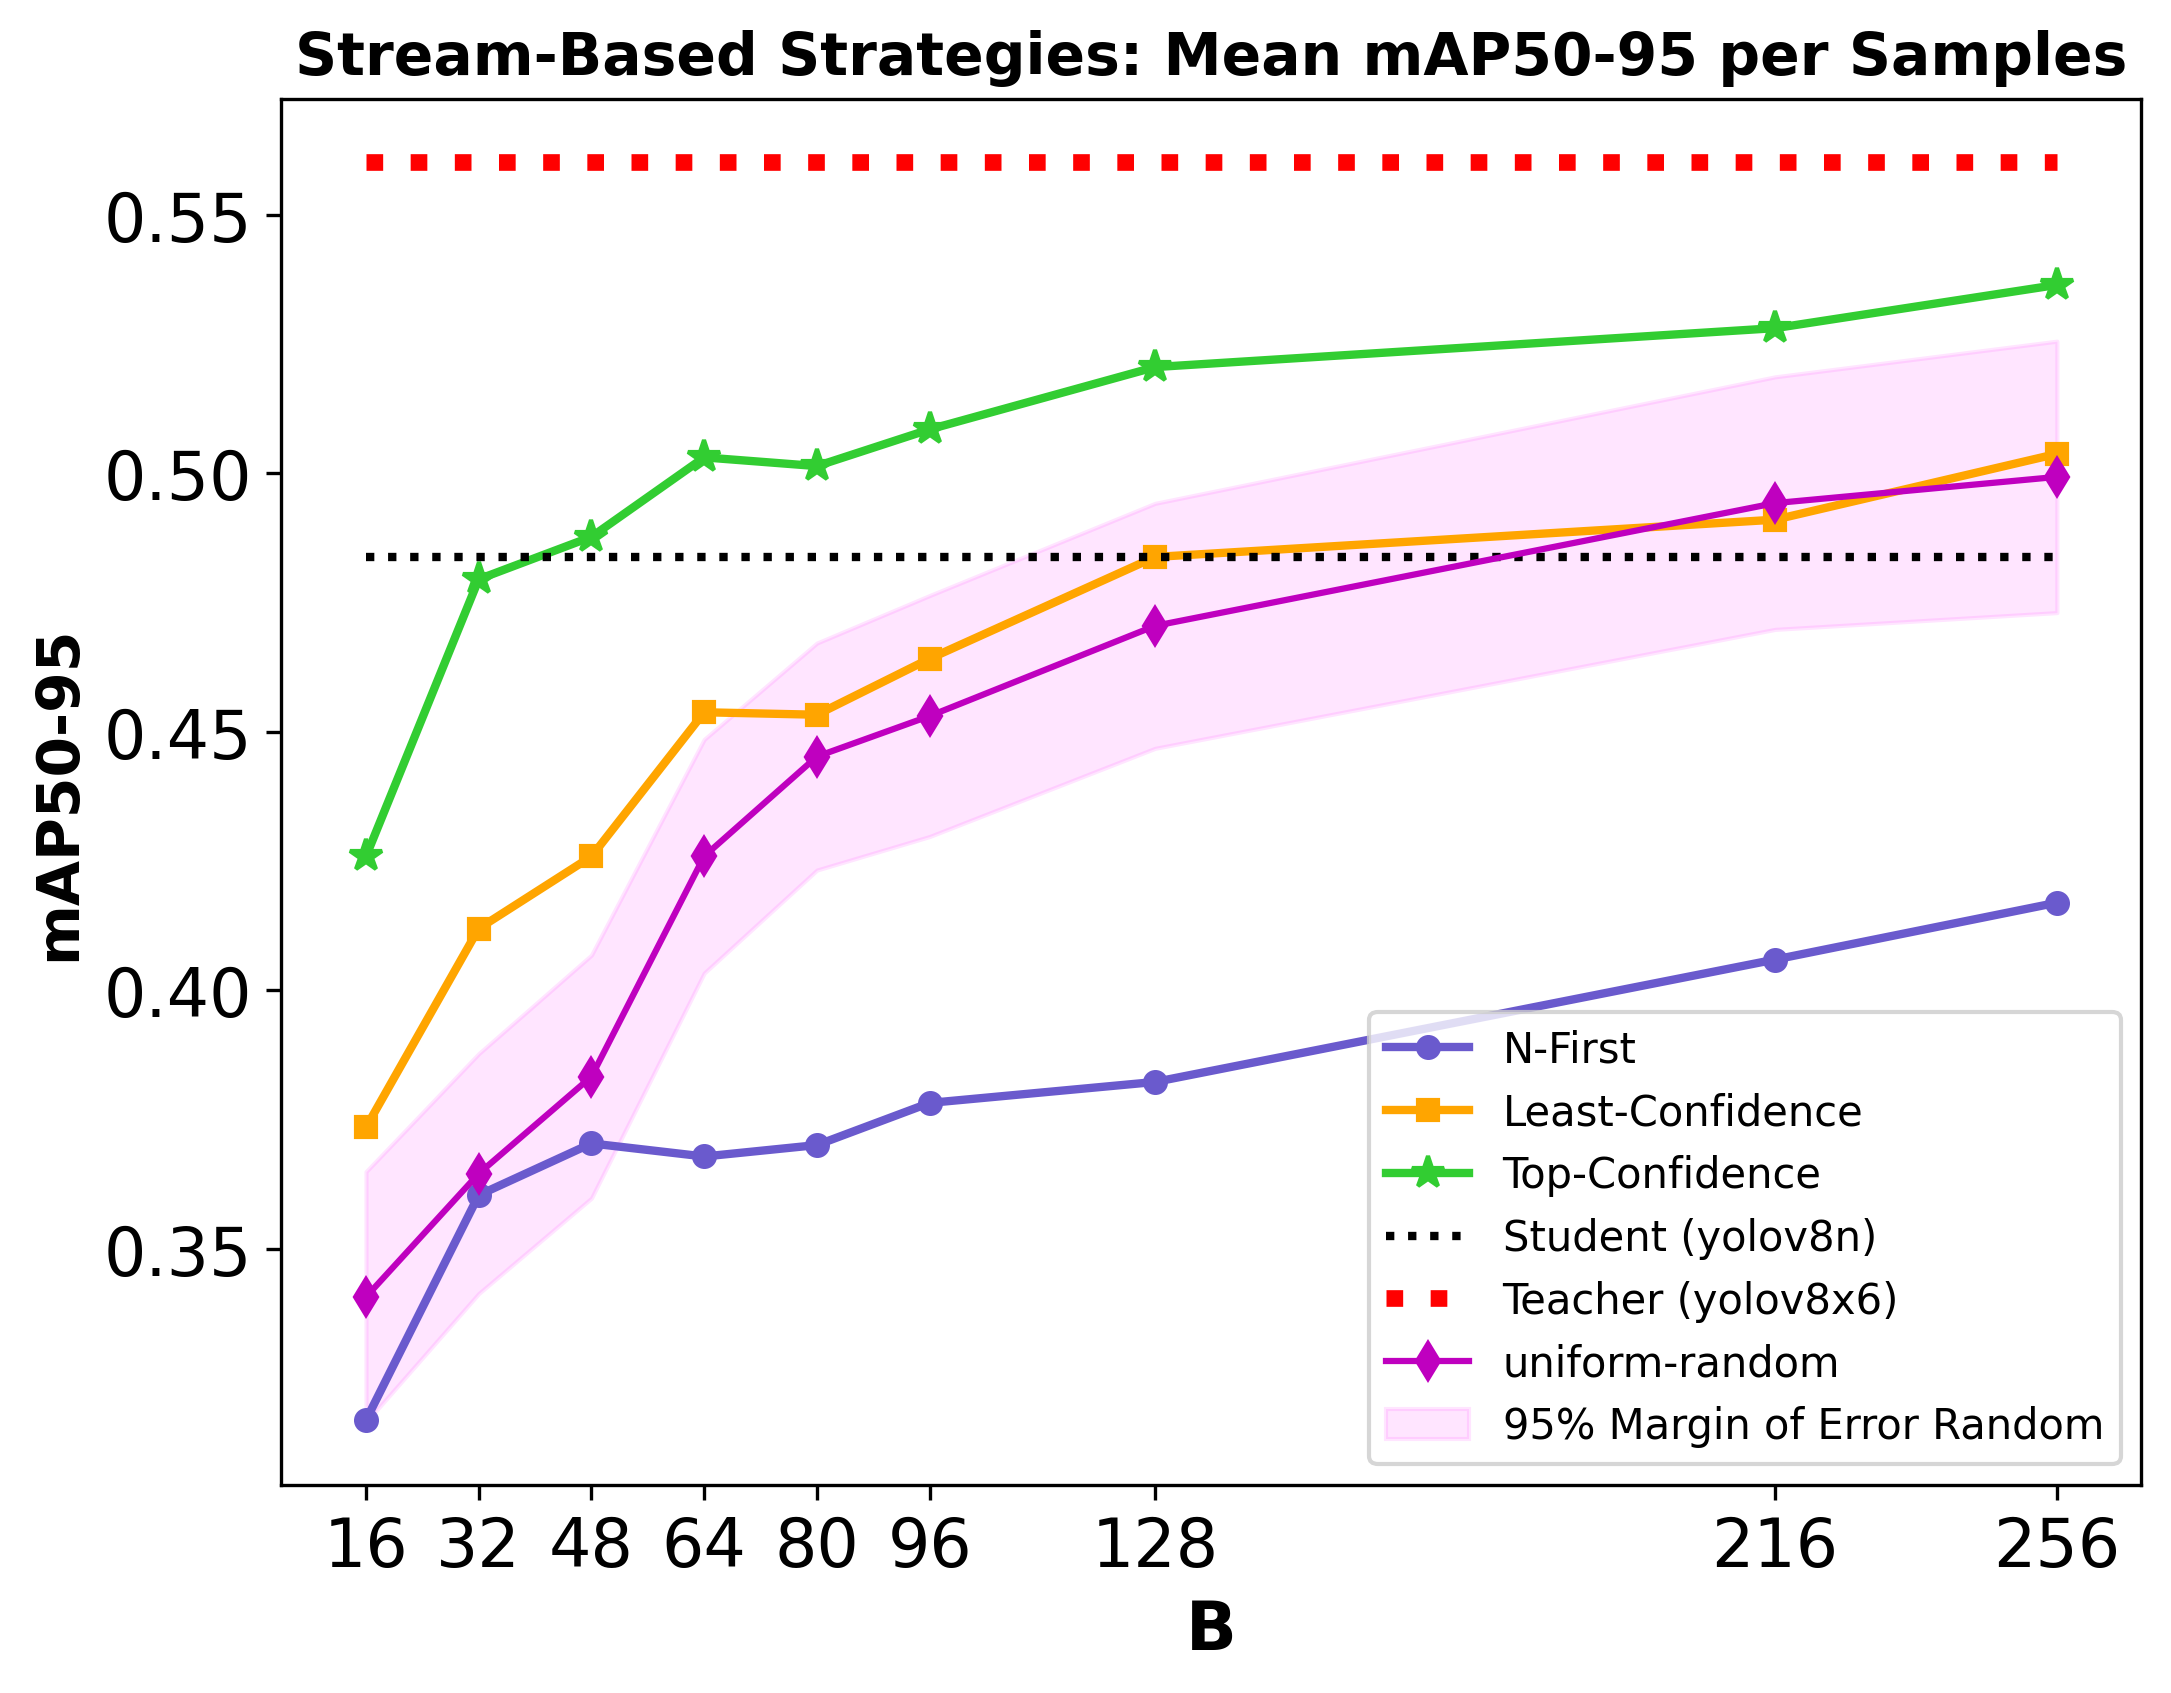

In [8]:
# Filter for a specific sample, strategy, and the domain-period combinations
df_strategies_sb, _ , _  = filter_df(df_all,
                                     same_domain=True,
                                     strategies=strategies_sb,
                                     samples=samples_small,
                                     dom_periods=scal_dom_periods,
                                     students=['yolov8n'],
                                     teachers=['yolov8x6'])


df_random_sb, _ , _ = filter_df(df_all, 
                      same_domain=True,
                      samples=samples_small,
                      dom_periods=scal_dom_periods,
                      prefix_random=prefix_random_sb)

plot_style={
    'title': 'Stream-Based Strategies: Mean mAP50-95 per Samples',
    'filename':"E:\Download\images-journal\sb-week-single.pdf"
}


pv=benchmark_strategies_plot(df_strategies_sb,
                          strategy_styles=strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_sb,
                          prefix_random=prefix_random_sb)



<h1> 1. MONTHS PERIODS <h1>

,mean_n-first,mean_thresh-least-confidence-max,mean_thresh-top-confidence-max,std_n-first,std_thresh-least-confidence-max,std_thresh-top-confidence-max,count_n-first,count_thresh-least-confidence-max,count_thresh-top-confidence-max
samples,,,,,,,,,
500,0.432,0.548,0.559,0.146,0.116,0.115,9,9,9
750,0.480,0.555,0.571,0.134,0.112,0.102,9,9,9
1000,0.487,0.565,0.572,0.136,0.108,0.104,9,9,9
1500,0.507,0.568,0.581,0.136,0.118,0.097,9,9,9
2000,0.487,0.573,0.581,0.198,0.113,0.106,9,9,9


,mean_uniform-random-0,mean_uniform-random-1,mean_uniform-random-2,mean_uniform-random-3,mean_uniform-random-4,mean_uniform-random-5,std_uniform-random-0,std_uniform-random-1,std_uniform-random-2,std_uniform-random-3,std_uniform-random-4,std_uniform-random-5,count_uniform-random-0,count_uniform-random-1,count_uniform-random-2,count_uniform-random-3,count_uniform-random-4,count_uniform-random-5
samples,,,,,,,,,,,,,,,,,,
500,0.538,0.537,0.506,0.543,0.527,0.500,0.122,0.129,0.213,0.113,0.130,0.208,9,9,9,9,9,9
750,0.550,0.556,0.550,0.555,0.528,0.544,0.122,0.120,0.123,0.105,0.160,0.127,9,9,9,9,9,9
1000,0.556,0.561,0.550,0.560,0.539,0.556,0.120,0.119,0.138,0.116,0.155,0.124,9,9,9,9,9,9
1500,0.552,0.557,0.560,0.555,0.552,0.561,0.145,0.142,0.134,0.135,0.152,0.129,9,9,9,9,9,9
2000,0.575,0.576,0.575,0.575,0.543,0.566,0.123,0.120,0.135,0.118,0.198,0.140,9,9,9,9,9,9


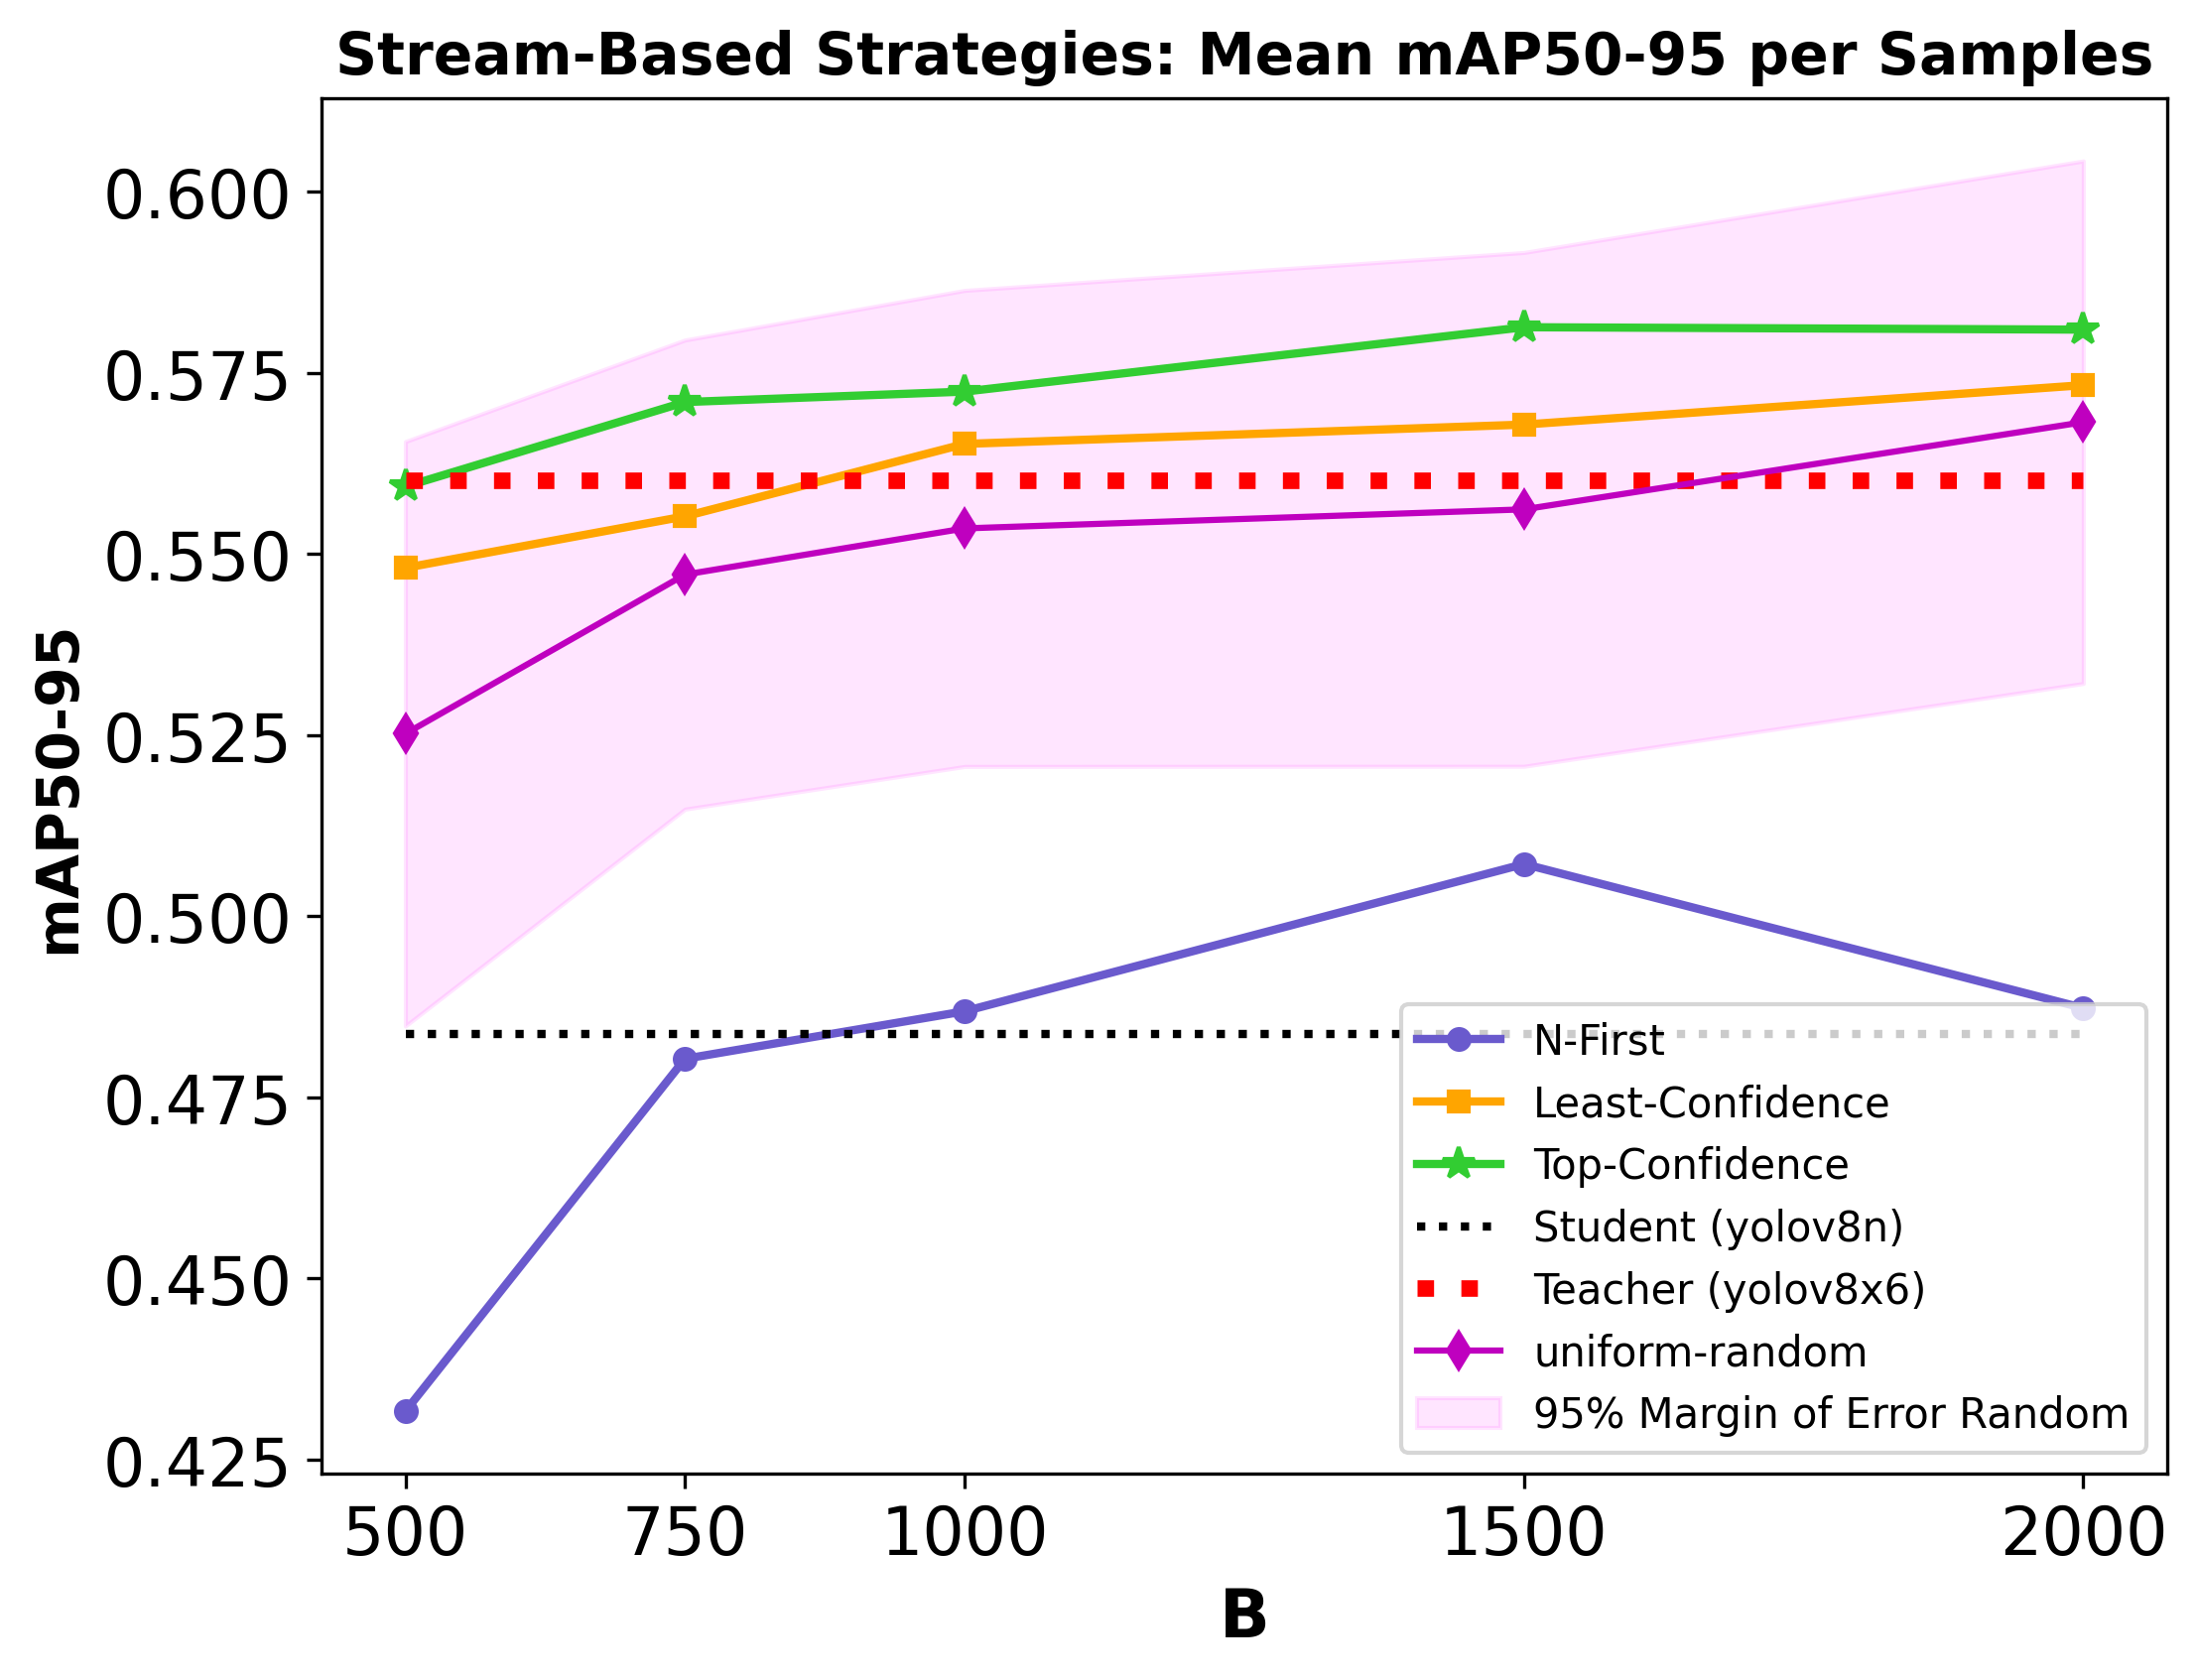

In [9]:
month_samples=[500,750,1000,1500,2000]
strategies_month=['thresholded01720-top-confidence-max',
                  'thresholded01720-least-confidence-max',
                  "thresholded025720-top-confidence-max",
                  "thresholded025720-least-confidence-max",
                  'thresholded055720-top-confidence-max',
                  'thresholded055720-least-confidence-max',
                  'thresholded-top-confidence01720-max',
                  'thresholded-least-confidence01720-max']

df_strategy_nfirst, _ , _  = filter_df(df_all,
                                       same_domain=True,
                                       source_dataset=['WALT'],
                                       dom_periods=restricted_dom_periods,
                                       samples=month_samples,
                                       strategies=['n-first'],
                                       students=['yolov8n'],
                                       teachers=['yolov8x6'])

df_strategies_monthsb, _ , _  = filter_df(df_all,
                                          same_domain=True,
                                          source_dataset=['WALT'],
                                          dom_periods=month_dom_periods,
                                          samples=month_samples,
                                          strategies=strategies_month,
                                          students=['yolov8n'],
                                          teachers=['yolov8x6'])

def rename_strategy(strategy):
    if "top" in strategy:
        return "thresh-top-confidence-max"
    elif "least" in strategy:
        return "thresh-least-confidence-max"
    else:
        return strategy  # return the strategy as is if it doesn't match the criteria

df_strategies_monthsb['strategy'] = df_strategies_monthsb['strategy'].apply(rename_strategy)

df_combined = pd.concat([df_strategies_monthsb, df_strategy_nfirst], ignore_index=True)


# List to hold dataframes
dfs = []

random_month=['uniform-random01',
              'uniform-random055',
              'uniform-random025']


# Loop through paths and read the data
for prefix in random_month:
    df_rand, _ , _ = filter_df(df_all,
                               same_domain=True,
                               samples=month_samples,
                               dom_periods=month_dom_periods,
                               prefix_random=prefix)
    dfs.append(df_rand)

# Concatenate all the dataframes into one
df_rand = pd.concat(dfs, ignore_index=True)
    
# Using regular expressions to replace the strategy names
df_rand['strategy'] = df_rand['strategy'].str.replace(r'uniform-random0(1|55|25)-(\d+)', r'uniform-random-\2', regex=True)


sb_strategy_styles = {
    'n-first': {'color': 'slateblue', 'marker': 'o','label':'N-First'},
    'thresh-top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'Top-Confidence','markersize':8},
    'thresh-least-confidence-max': {'color': 'orange', 'marker': 's','label':'Least-Confidence'},
}


plot_style={
    'tick_positions' : month_samples,
    'tick_labels':[str(value) for value in month_samples],
    'title': 'Stream-Based Strategies: Mean mAP50-95 per Samples',
    'setGrid': False,
    'filename':"E:\Download\images-journal\sb-month-single.pdf"
}


pv=benchmark_strategies_plot(df_combined,
                             strategy_styles=sb_strategy_styles,
                             plot_style=plot_style,
                             baseline_df=df_baseline_default,
                             baseline_styles=baseline_styles_default,
                             random_df=df_rand,
                             prefix_random="uniform-random")


<h1> <font color="blue"> 2. CLUSTERING </font><h1>


<h2> <font color="blue"> 2.1 UTILS </font><h2>

In [10]:
def plot_heatmap(cross_domain_df, strategy, samples):
    
    grouped_df = cross_domain_df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()
    pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

    fig1, axes1 = plt.subplots(1, 1, figsize=(12, 10))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes1, annot_kws={"size": 16})
    axes1.set_title( r"Cross-Domain Models mAP50-95, $B=$" + str(samples) + r"; $SELECT=$Top-Confidence ", weight='bold', fontsize=20, pad=16)
    axes1.set_xlabel('TARGET DOMAIN', weight='bold',fontsize=14, labelpad=10)
    axes1.set_ylabel('SOURCE DOMAIN', weight='bold',fontsize=14, labelpad=10)
    plt.xticks(rotation=45) # Rotating x-axis labels for better readability
    file_name1 = f"{fig_dst_path}heatmap_{strategy}_{samples}_unadjusted.pdf"
        # Increase the tick labels font size here
    plt.xticks(fontsize=16)  # Increase fontsize to your preference
    plt.yticks(fontsize=16)  # Increase fontsize to your preference
    plt.tight_layout(pad=3)  # Added padding for layout
    colorbar = axes1.collections[0].colorbar
    colorbar.set_label('mAP50-95', weight='bold', fontsize=16)
        
    # Set the desired ticks on the colorbar
    colorbar.set_ticks([0.1, 0.2, 0.4, 0.6])
    # Set the tick label size
    colorbar.ax.tick_params(labelsize=16)
    
    plt.savefig(file_name1, format='pdf', dpi=300,bbox_inches='tight')#

   ## pivot_df_diag_row_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)
   #### fig2, axes2 = plt.subplots(1, 1, figsize=(12, 8))  # Adjusted the figure size
  #   ## Applying the heatmap
     ##sns.heatmap(pivot_df_diag_row_adjusted, vmin=-0.45, vmax=0.0, annot=True, cmap='RdBu', ax=axes2,
   #   #      annot_kws={"size": 16},linewidths=.5, linecolor='grey')  # Adjusted annotation size and added color bar label
  #  # Setting title and labels with adjusted font sizes
    #axes2.set_title('Assessing Models Transferability: Heatmap with $Rows$ $−$ $Diagonal$', weight='bold', fontsize=16)
    ##axes2.set_xlabel('TARGET DOMAIN', weight='bold', fontsize=14)
    #axes2.set_ylabel('SOURCE DOMAIN', weight='bold', fontsize=14)
        # Increase the tick labels font size here
    #plt.xticks(fontsize=12)  # Increase fontsize to your preference
    #plt.yticks(fontsize=12)  # Increase fontsize to your preference
    #plt.xticks(rotation=45) # Rotating x-axis labels for better readability
    # Saving the figure
    #file_name2 = f"{fig_dst_path}heatmap_{strategy}_{samples}_row_adjusted.pdf"
    #plt.savefig(file_name2, format='pdf', dpi=300, bbox_inches='tight')
    
    
    ### DEPRECATED
    fig3, axes3 = plt.subplots(1, 1, figsize=(12, 10))
    pivot_df_diag_column_adjusted = pivot_df.apply(lambda column: column - column[column.name], axis=0)
    sns.heatmap(pivot_df_diag_column_adjusted, vmin=-0.30, vmax=0.0, annot=True, cmap='RdBu', ax=axes3, annot_kws={"size": 16},
                linewidths=.5, linecolor='grey')
    axes3.set_title("Adjusted $M$ : Domain-Specific Model Superiority and Transferability", weight='bold', fontsize=20, pad=16)
    axes3.set_xlabel('TARGET DOMAIN', weight='bold',fontsize=16, labelpad=10)
    axes3.set_ylabel('SOURCE DOMAIN', weight='bold',fontsize=16, labelpad=10)
    # Include a color bar label to explain the heatmap legend
    colorbar = axes3.collections[0].colorbar
    colorbar.set_label('mAP50-95 Decrease', weight='bold', fontsize=16)
    # After creating your heatmap with sns.heatmap, which returns an Axes object
    cbar = axes3.collections[0].colorbar

    # Set the desired ticks on the colorbar
    cbar.set_ticks([0.0, -0.1, -0.2, -0.3])

    # Set the tick label size
    cbar.ax.tick_params(labelsize=16)
    
    plt.xticks(rotation=45,fontsize=16)  # Increase fontsize to your preference
    plt.yticks(fontsize=16)  # Increase fontsize to your preference
    plt.tight_layout(pad=3)  # Added padding for layout

    file_name3 = f"{fig_dst_path}heatmap_{strategy}_{samples}_column_adjusted.pdf"
    plt.savefig(file_name3, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return pivot_df, pivot_df_diag_column_adjusted #, pivot_df_diag_column_adjusted

<h2> <font color="blue"> 2.2 Cross-domain performance </font><h2>

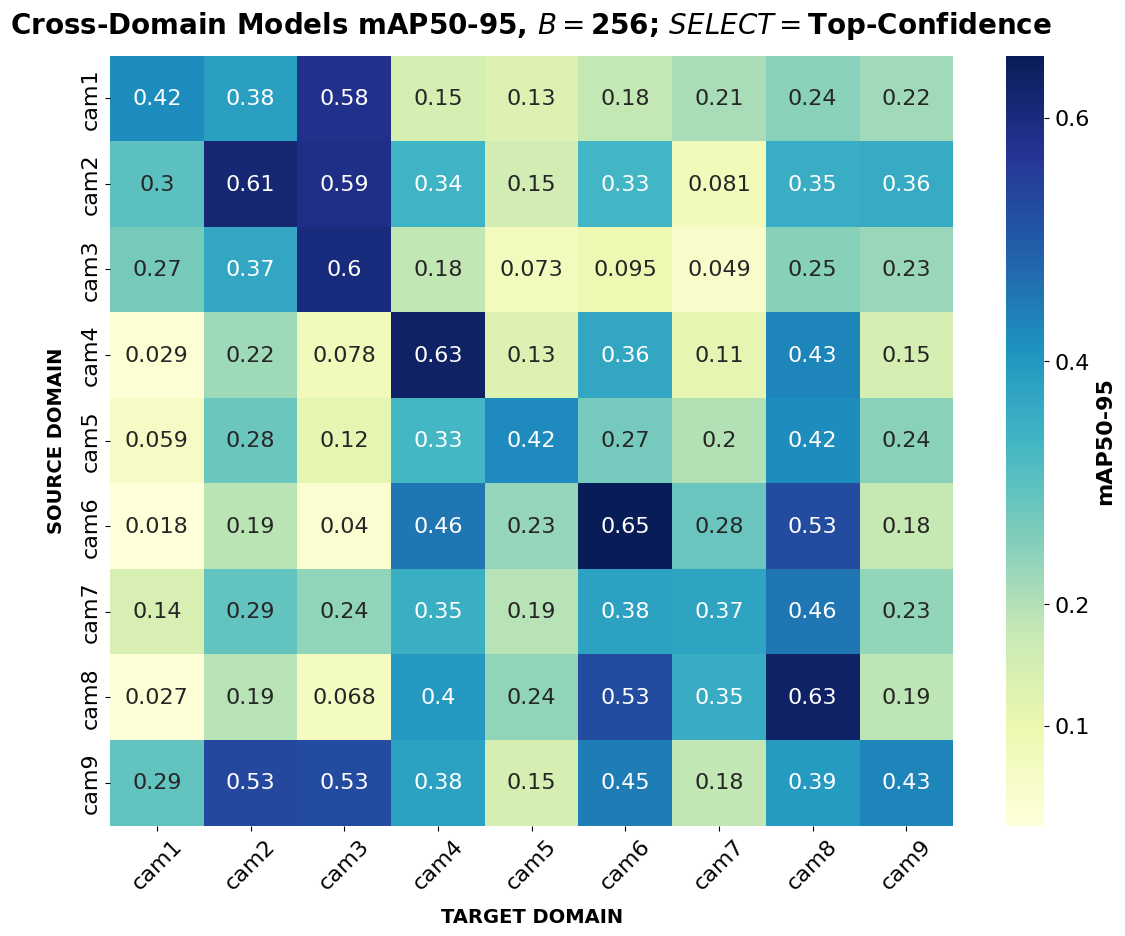

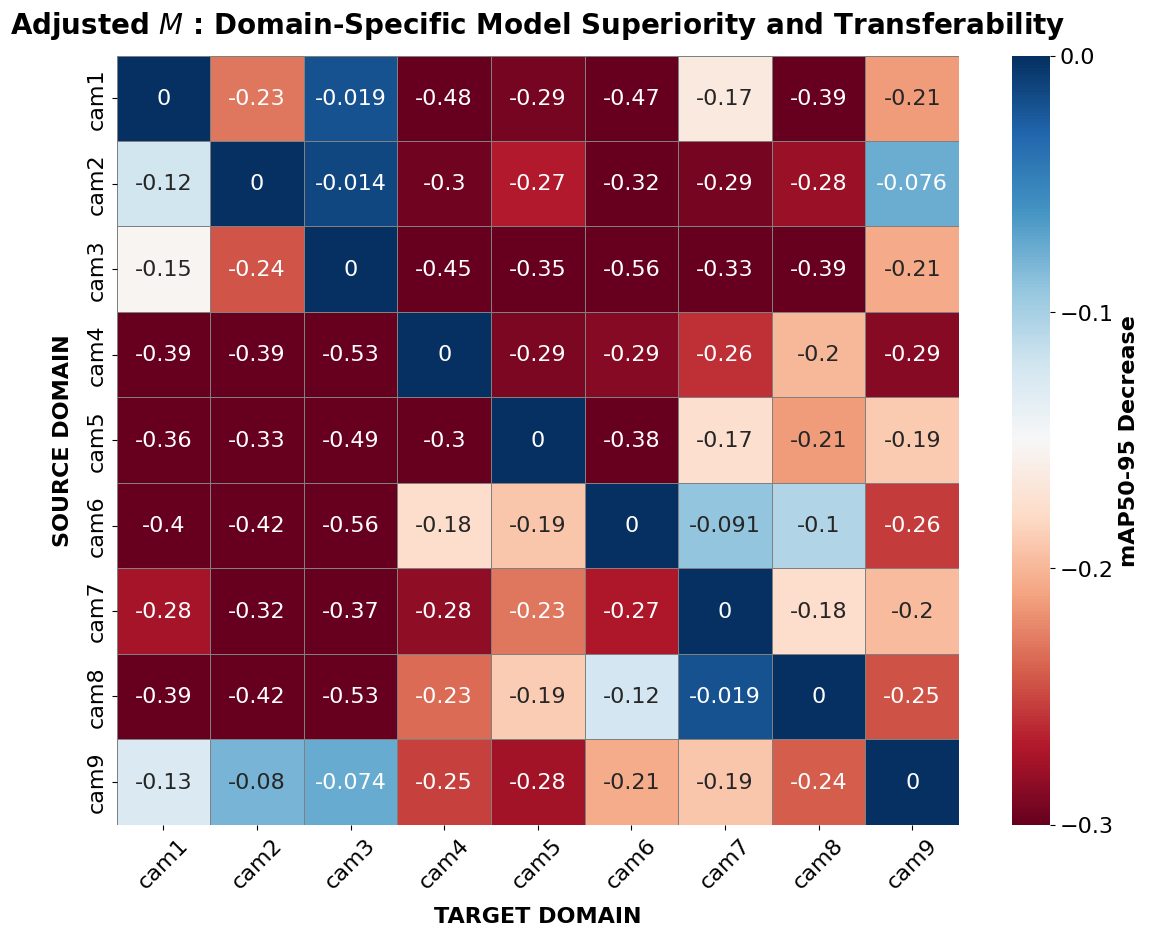

In [11]:
samples=256
df_cross_domain, _, _ = filter_df(df_all,
                                strategies=['thresholded-top-confidence-max'],
                                dom_periods=restricted_dom_periods,
                                samples=[samples])

pivot_sb, pivot_sb_col_adj = plot_heatmap(df_cross_domain,
                                          strategy="Top-Confidence",
                                          samples=samples)

<h2> <font color="blue"> 2.3 Hiearchichal Clustering </font><h2>

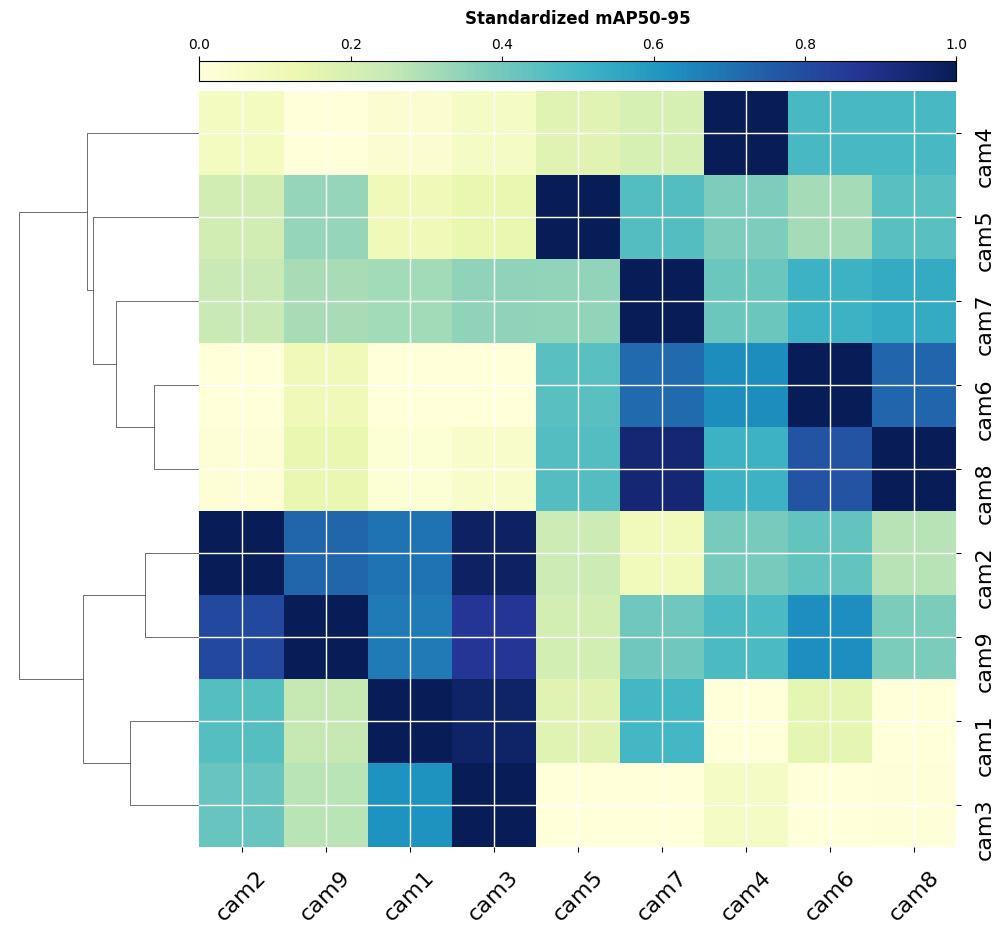

In [12]:
# Clear any previous name definitions for rows and columns
pivot_sb.index.name = None
pivot_sb.columns.name = None

# Create the clustermap
grid_sb = sns.clustermap(pivot_sb, cmap='YlGnBu', standard_scale=1, figsize=(10, 10), cbar_kws={"orientation": "horizontal"})


# Assuming 'grid_sb' is your existing ClusterGrid object from seaborn

# Find the positions of the heatmap and the colorbar
heatmap_pos = grid_sb.ax_heatmap.get_position()
cbar_pos = grid_sb.cbar_pos

# Create new axes for the horizontal colorbar above the heatmap
cbar_ax = grid_sb.fig.add_axes([heatmap_pos.x0, heatmap_pos.y1 + 0.01, heatmap_pos.width, 0.02])

# Draw the colorbar into the new axes
cbar = grid_sb.fig.colorbar(grid_sb.ax_heatmap.collections[0], cax=cbar_ax, orientation='horizontal')

# Set the colorbar ticks and label position
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

cbar.set_label('Standardized mAP50-95', fontsize=12, weight='bold', labelpad=10)

# Hide the original colorbar
grid_sb.cax.set_visible(False)


# Set font size for the tick labels
plt.setp(grid_sb.ax_heatmap.get_xticklabels(), fontsize=16, rotation=45)
plt.setp(grid_sb.ax_heatmap.get_yticklabels(), fontsize=16)

# Set the dendrogram visibility
grid_sb.ax_row_dendrogram.set_visible(True)

grid_sb.ax_col_dendrogram.set_visible(False)

# Additional improvements
grid_sb.ax_heatmap.set_facecolor('#dddddd')
grid_sb.ax_heatmap.grid(True, which='both', color='white', linewidth=1)

# Tick positions are set on the conventional 'left' and 'bottom'
grid_sb.ax_heatmap.yaxis.set_ticks_position('right')
grid_sb.ax_heatmap.xaxis.set_ticks_position('bottom')

# Set padding for tick labels
grid_sb.ax_heatmap.yaxis.set_tick_params(pad=10)
grid_sb.ax_heatmap.xaxis.set_tick_params(pad=10)

# Save the clustermap
grid_sb.fig.savefig("E:\Download\images-journal\clustermap.pdf", dpi=300, bbox_inches='tight')

<h2> <font color="blue"> 2.3 Definition of the clustering </font><h2>

In [13]:
def calculate_clusters(linkage_matrix, min_threshold, max_threshold, step):
    first_occurrences = {}
    seen_clusters = set()

    for threshold in np.arange(min_threshold, max_threshold, step):
        clusters = fcluster(linkage_matrix, threshold, criterion='distance')
        num_clusters = len(np.unique(clusters))
        
        if num_clusters not in seen_clusters:
            seen_clusters.add(num_clusters)
            first_occurrences[num_clusters] = {'threshold': threshold, 'clusters': []}
            
            for cluster_num in range(1, num_clusters + 1):
                indices = np.where(clusters == cluster_num)[0] + 1 # Increment indices by 1
                first_occurrences[num_clusters]['clusters'].append(indices)
    return first_occurrences

In [18]:
# Get the linkage matrix for the rows
row_clusters_sb = calculate_clusters(grid_sb.dendrogram_row.linkage, 0.5, 1.5, 0.05)

# Add the third grid
#row_clusters_sb_row_adj = calculate_clusters(grid_sb_row_adj.dendrogram_row.linkage, 0.5, 2, 0.05)

# Function to format the threshold with two decimal places
def format_threshold(threshold):
    return "{:.2f}".format(threshold)

# Set the maximum number of num_clusters to display
max_num_clusters_to_display = 6

# Get the sorted unique num_clusters
sorted_num_clusters = sorted(set(row_clusters_sb.keys()))

# Limit the number of num_clusters to display
num_clusters_to_display = sorted_num_clusters[:max_num_clusters_to_display]

# Iterate through clusters and print results side by side for the selected num_clusters
for num_clusters in num_clusters_to_display:
    # Grid 1
    if num_clusters in row_clusters_sb:
        print('Grid 1:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_sb[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_sb[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Grid 1: No clusters found at this threshold.')


Grid 1:
2 clusters at threshold 1.15:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]
Grid 1:
3 clusters at threshold 1.10:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]
Grid 1:
4 clusters at threshold 1.05:
Cluster 1: [5 6 7 8]
Cluster 2: [4]
Cluster 3: [2 9]
Cluster 4: [1 3]
Grid 1:
5 clusters at threshold 0.85:
Cluster 1: [6 7 8]
Cluster 2: [5]
Cluster 3: [4]
Cluster 4: [2 9]
Cluster 5: [1 3]
Grid 1:
6 clusters at threshold 0.70:
Cluster 1: [6 8]
Cluster 2: [7]
Cluster 3: [5]
Cluster 4: [4]
Cluster 5: [2 9]
Cluster 6: [1 3]
Grid 1:
7 clusters at threshold 0.55:
Cluster 1: [6 8]
Cluster 2: [7]
Cluster 3: [5]
Cluster 4: [4]
Cluster 5: [2 9]
Cluster 6: [1]
Cluster 7: [3]


<h2> <font color="blue"> 2.3 Clustering Performance Analysis </font> </h2>

<h2> UTILS </h2>

In [24]:
def assign_cluster(cam, clusters, dom_periods):
    inclusters=[]
    outclusters=[]
    for cluster in clusters:
        a,b,c,d=process_domains_periods(cluster['source_domain'], cluster['source_period'], dom_periods)
        if(cam in b):
            inclusters.append(cluster)
        else:
            outclusters.append(cluster)
            
    return inclusters,outclusters  

def generate_cameras_pairs(input_string):
    # Find the index of the '-week'
    week_index = input_string.index('-week')

    # Get the cameras and weeks as lists of characters
    cameras = input_string[:week_index].split('o')
    weeks = input_string[week_index+5:].split('o')

    # Add the 'cam' prefix to each camera if not already there
    cameras = ['cam' + cam if not cam.startswith('cam') else cam for cam in cameras]
    weeks = ['week' + week for week in weeks]

    # Check that the number of cameras is equal to the number of weeks
    if len(cameras) != len(weeks):
        raise ValueError("The number of cameras must be equal to the number of weeks")

    # Generate the output
    output = list(zip(cameras, weeks))
    
    return output


def process_domains_periods(source_domain, source_period, eligible_domain_periods):
    joined_string = source_domain + "-" + source_period
    domains_periods = generate_cameras_pairs(joined_string)
    included_domains = [pair[0] for pair in domains_periods]
    excluded_domains_periods = [pair for pair in eligible_domain_periods if pair not in domains_periods]
    excluded_domains = [pair[0] for pair in excluded_domains_periods]
    return domains_periods, included_domains,excluded_domains_periods,excluded_domains


<h2> <font color="blue"> 2.4 CLUSTERING ASSIGNATION </font> </h2>

In [31]:
cluster_data = [
    (1, 'cam1o2o3o4o5o6o7o8o9', 'week1o1o5o2o3o4o4o3o1'),
    (2, 'cam1o2o3o9', 'week1o1o5o1'),
    (2, 'cam4o5o6o7o8', 'week2o3o4o4o3'),
    (3, 'cam4o5o6o7o8', 'week2o3o4o4o3'),
    (3, 'cam1o3', 'week1o5'),
    (3, 'cam2o9', 'week1o1'),
    # Added number 4 clusters
    #(4, 'cam5o6o7o8', 'week3o4o4o3'),
    #(4, 'cam1o3', 'week1o5'),
    #(4, 'cam2o9', 'week1o1'),
    #(4, 'cam4', 'week2'),
    # Continuing with number 5 clusters
    (5, 'cam6o7o8', 'week4o4o3'),
    (5, 'cam1o3', 'week1o5'),
    (5, 'cam2o9', 'week1o1'),
    (5, 'cam4', 'week2'),
    (5, 'cam5', 'week3')
]

clusters = [{'number': num, 'source_domain': domain, 'source_period': period} for num, domain, period in cluster_data]

cluster_month_data = [
    (1, 'cam1o2o3o4o5o6o7o8o9', 'week12345o12345o5o23o1235o134o4o3o12'),
    (2, 'cam1o2o3o9', 'week12345o12345o5o12'),
    (2, 'cam4o5o6o7o8', 'week23o1235o134o4o3'),
    (3, 'cam4o5o6o7o8', 'week23o1235o134o4o3'),
    (3, 'cam1o3', 'week12345o5'),
    (3, 'cam2o9', 'week12345o12'),
    # Added number 4 clusters (previously commented out)
    #(4, 'cam5o6o7o8', 'week3o4o4o3'),
    #(4, 'cam1o3', 'week1o5'),
    #(4, 'cam2o9', 'week1o1'),
    #(4, 'cam4', 'week2'),
    (5, 'cam6o7o8', 'week134o4o3'),
    (5, 'cam1o3', 'week12345o5'),
    (5, 'cam2o9', 'week12345o12'),
    (5, 'cam4', 'week23'),
    (5, 'cam5', 'week1235')
]
clusters_month = [{'number': num, 'source_domain': domain, 'source_period': period} for num, domain, period in cluster_month_data]


<h2> UTILS </h2>

In [21]:
def total_samples_cluster(cam_week_tuples, strategy, samples, clusters, df, dom_periods):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data1={}
        
        cam, week = cam_week_tuple
        data1["target_domain"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters,dom_periods)
        # Loop over each sample
        for sample in samples:
            data1["samples"]=int(sample*9)
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample],
                                        students=['yolov8n'])
            data1["strategy"]= '9-models'
            data1["mAP50-95"]=mean_cam_self
            result_df = pd.concat([result_df, pd.DataFrame([data1])], ignore_index=True)

            for cls in inclusters:
                data2={}
                data2["target_domain"]=cam
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam],
                                           students=['yolov8n'])
                data2[f"samples"]=int(number_of_samples*9/len(in_cameras))
                data2[f"strategy"]=f"{cls['number']}-models"
                data2["mAP50-95"] = cluster_mean
                data2[f"smpls cls_{cls['number']}"]=int(number_of_samples)
                data2[f"cam cls_{cls['number']}"]=b
                
                result_df = pd.concat([result_df, pd.DataFrame([data2])], ignore_index=True)
        
    return result_df

In [22]:
######################################################### STYLE ############################################
cluster_strategy_styles = {
    '1-models': {'color': 'slateblue', 'marker': 'o','label':r'$K=1$'},
    '2-models': {'color': 'm', 'marker': 'D','label': r'$K=2$'},
    '3-models': {'color': 'limegreen', 'marker': '*','label':r'$K=3$'},
    '5-models': {'color': 'darkslategray', 'marker': 'd','label':r'$K=5$'},
    '9-models': {'color': 'orange', 'marker': 's','label':r'$K=9$'},
}

df_baseline_limited, _ , _ = filter_df(df_all, 
                               source_dataset=['WALT'],
                               strategies=['yolov8x6'])

<h2> <font color="blue"> 3.1. Stream-Based WEEKLY CLUSTERING   </font> </h2>

,mean_1-models,mean_2-models,mean_3-models,mean_5-models,mean_9-models,std_1-models,std_2-models,std_3-models,std_5-models,std_9-models,count_1-models,count_2-models,count_3-models,count_5-models,count_9-models
samples,,,,,,,,,,,,,,,
144,0.489,0.488,0.482,0.459,0.428,0.121,0.111,0.115,0.124,0.122,9,9,9,9,9
288,0.505,0.489,0.485,0.500,0.485,0.121,0.122,0.121,0.106,0.108,9,9,9,9,9
432,0.521,0.469,0.464,0.509,0.490,0.112,0.122,0.116,0.109,0.113,9,9,9,9,9
576,0.525,0.534,0.509,0.515,0.506,0.119,0.118,0.115,0.098,0.096,9,9,9,9,9
720,0.531,0.526,0.517,0.519,0.496,0.111,0.115,0.115,0.109,0.106,9,9,9,9,9
864,0.545,0.530,0.521,0.522,0.502,0.122,0.113,0.118,0.116,0.113,9,9,9,9,9
1944,0.559,0.561,0.550,0.531,0.529,0.105,0.107,0.112,0.115,0.102,9,9,9,9,9
2304,0.553,0.564,0.558,0.544,0.531,0.107,0.108,0.108,0.106,0.115,9,9,9,9,9


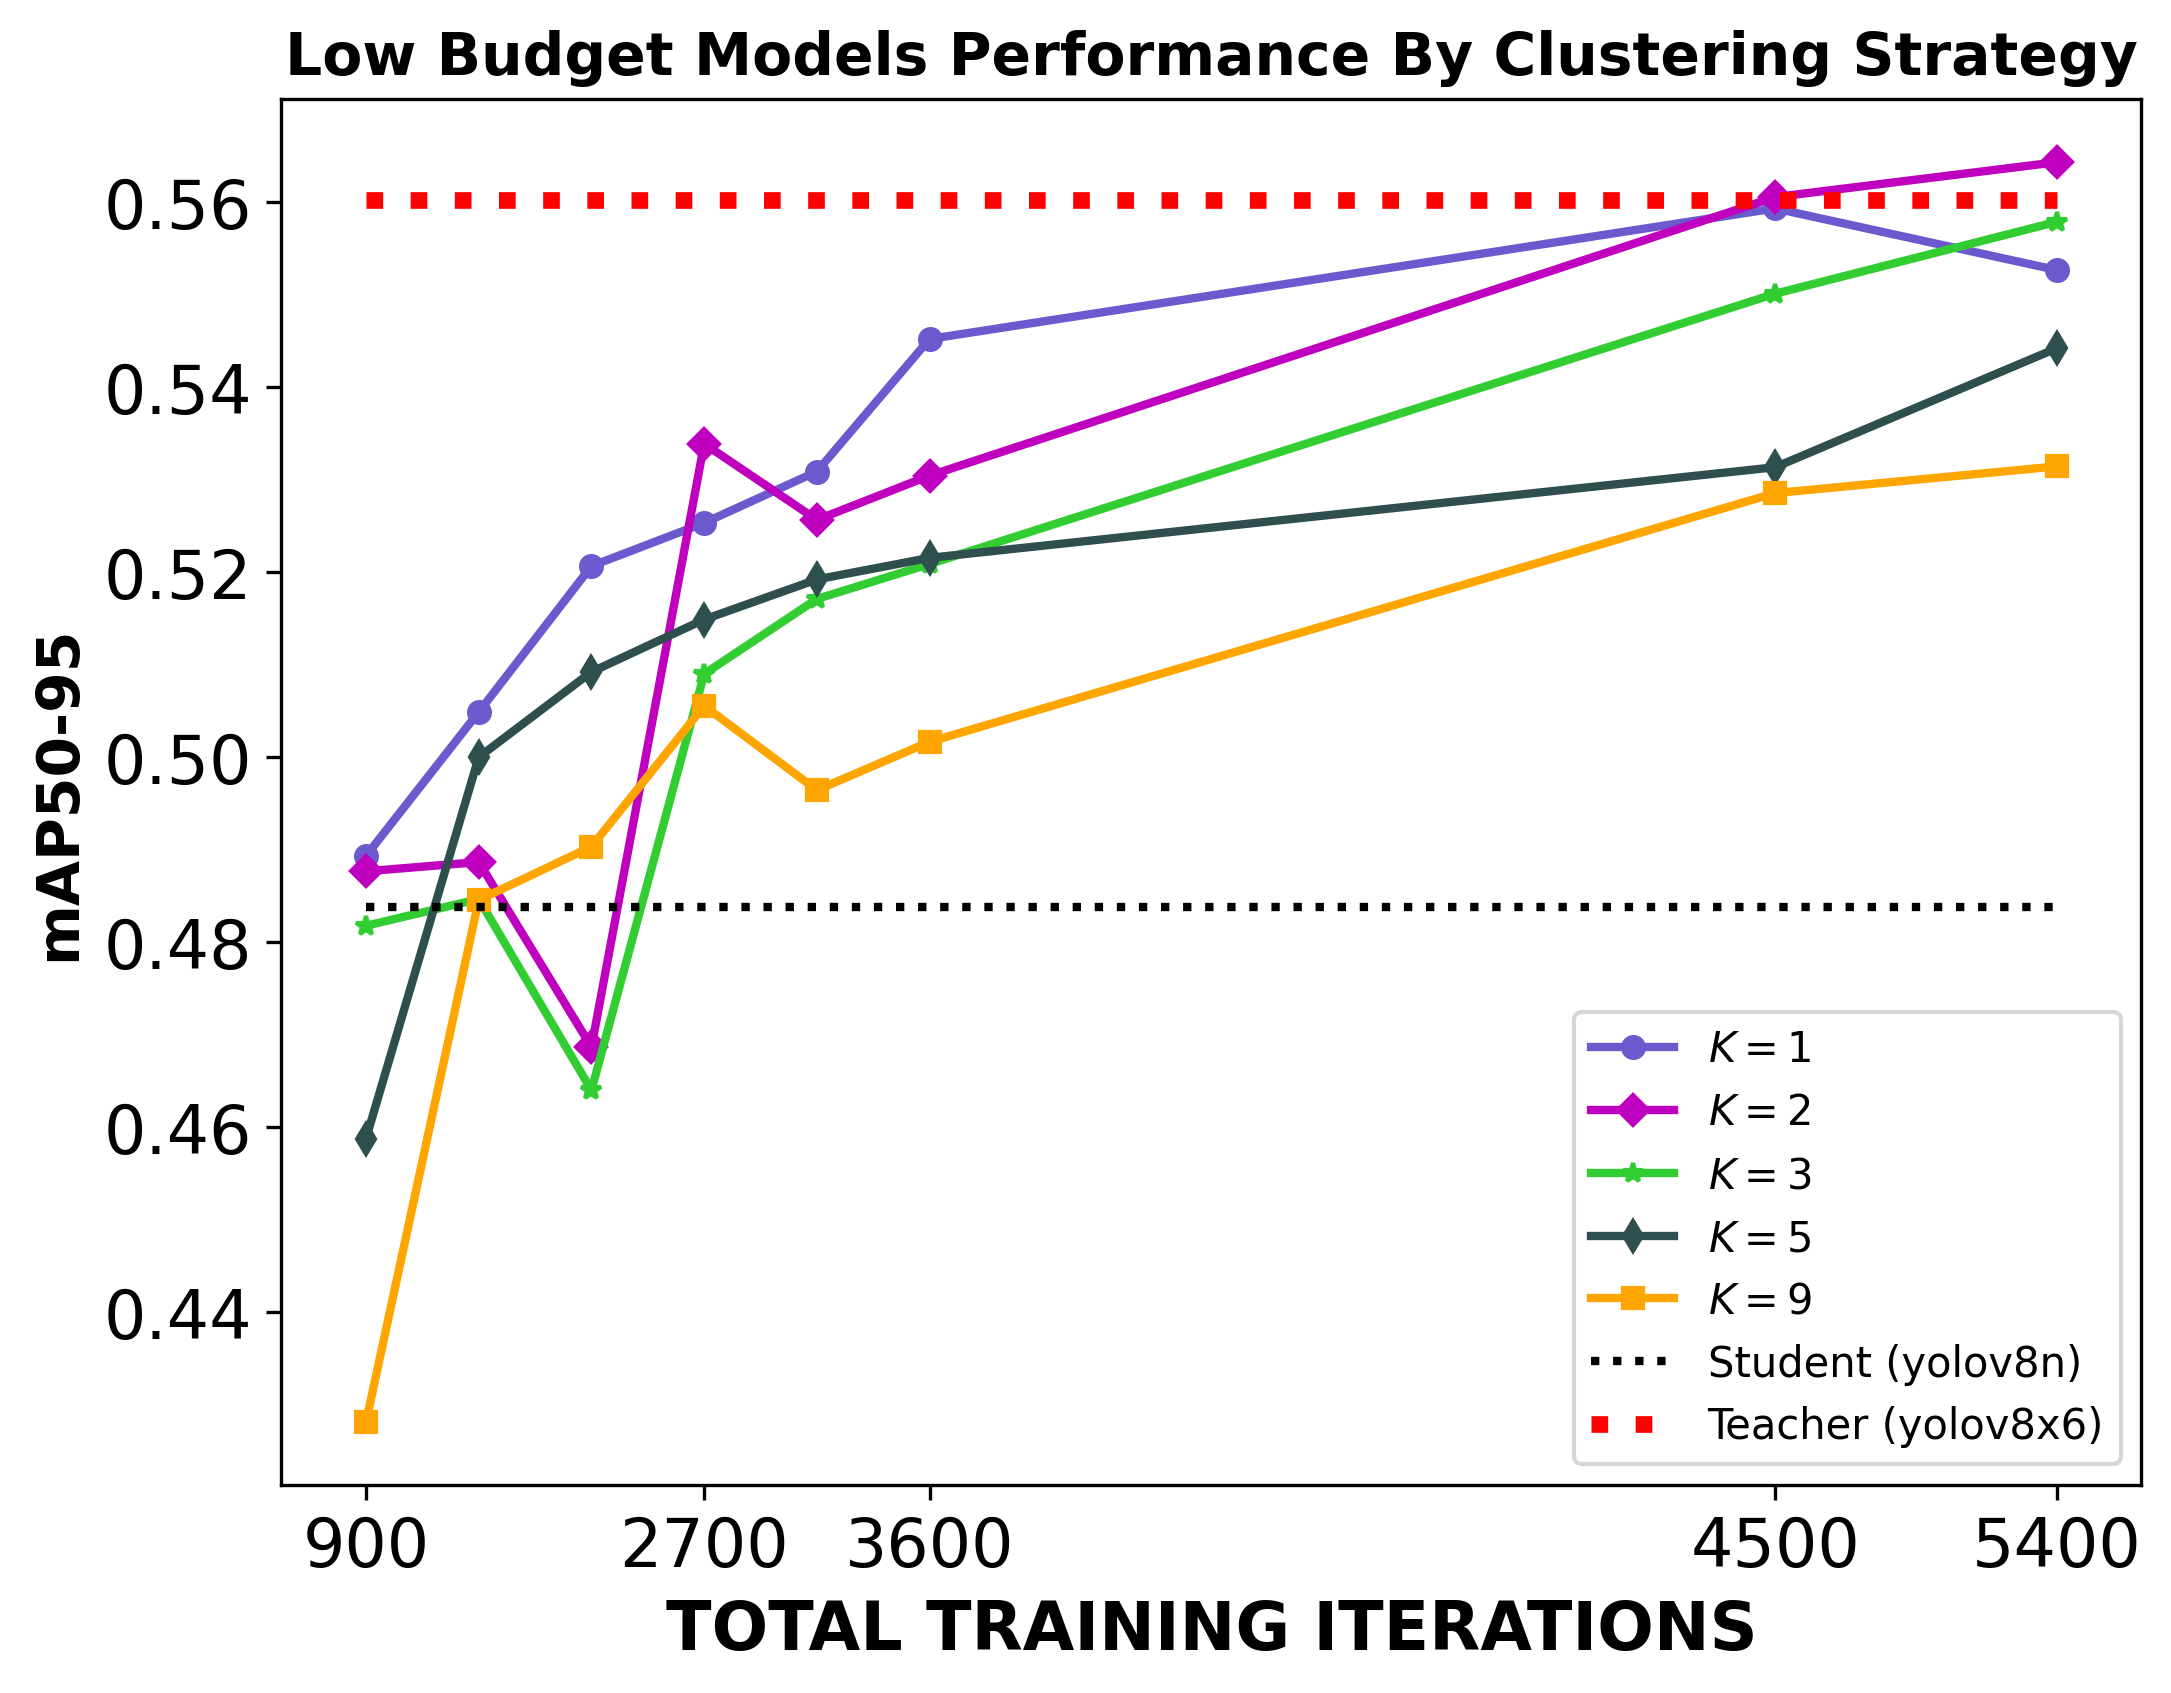

In [25]:
samples_sb = [16,32,48,64, 80, 96, 216,256]   # replace with your samples
df_clustering_sb = total_samples_cluster(restricted_dom_periods, 
                                         'thresholded-top-confidence-max', 
                                         samples_sb, clusters, df_all, restricted_dom_periods)

total_samples_sb = [int((x * 9)/16)*100 for x in samples_sb]
todisplay=[total_samples_sb[0],
           total_samples_sb[2],
           total_samples_sb[3],
           total_samples_sb[4],
           total_samples_sb[5]]

todispl_sb = [16,64,96,216,256]
total_todispl_sb = [x * 9 for x in todispl_sb]

plot_style={
    'tick_positions':total_todispl_sb,
    'tick_labels':[str(value) for value in todisplay],
    'title': 'Low Budget Models Performance By Clustering Strategy',
    'xlabel': r'TOTAL TRAINING ITERATIONS',
    'filename':"E:\Download\images-journal\sb-week-clustering.pdf"
}

benchmark_strategies_plot(df_clustering_sb, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

<h2> <font color="blue"> 3.2. Stream-Based WEEKLY CLUSTERING LARGE   </font> </h2>

In [ ]:
df_clustering_largesb = total_samples_cluster(restricted_dom_periods, 
                                         'thresholded09160-top-confidence-max', 
                                         samples_large, clusters, df_all, restricted_dom_periods)


total_samples_large = [x * 9 for x in samples_large]
todisplay=[total_samples_large[0],
                       total_samples_large[2],
                       total_samples_large[4],
                       total_samples_large[5],
                       total_samples_large[6],
                       total_samples_large[7],
                       total_samples_large[8],total_samples_large[9]]

plot_style={
    'tick_positions' : todisplay,
    'tick_labels':[str(value) for value in todisplay],
    'title': 'High Budget Clustering: Mean mAP50-95 by Total Budget',
    'xlabel': r'Total Training Iterations',
    'filename':"E:\Download\images-journal\sb-week-clustering-large.pdf"
}

benchmark_strategies_plot(df_clustering_largesb, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_limited,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

<h2> <font color="blue"> 3.3. Stream-Based MONTHLY CLUSTERING LARGE   </font> </h2>

In [ ]:
def rename_strategymulti(strategy):
    if "thresh-top-confidence-max" in strategy:
        return "thresh-top-confidence-max"
    elif "thresholded-top-confidence-adaptative-max" in strategy:
        return "thresh-top-confidence-max"
    else:
        return strategy  # return the strategy as is if it doesn't match the criteria
    
large_month_dom_periods=[('cam1o2o3o4o5o6o7o8o9', 'week12345o12345o5o23o1235o134o4o3o12'),
                            ('cam1o2o3o9', 'week12345o12345o5o12'),
                            ('cam4o5o6o7o8', 'week23o1235o134o4o3'), 
                            ('cam2o9', 'week12345o12'),
                            ('cam1o3', 'week12345o5'),
                            ('cam6o7o8', 'week134o4o3'),
                            ('cam5o6o7o8', 'week1235O134o4o3')]

df_multistream_month,_,_ = filter_df(df_all,
                                 dom_periods=large_month_dom_periods)

df_months_multi= pd.concat([df_multistream_month, df_combined], ignore_index=True)



df_months_multi['strategy'] = df_months_multi['strategy'].apply(rename_strategymulti)



samples_month=[500,750,1000,1500,2000]
df_clustering_month = total_samples_cluster(month_dom_periods, 
                                              'thresh-top-confidence-max',
                                              samples_month,
                                              clusters_month,
                                              df_months_multi, 
                                              month_dom_periods)


total_samples_month = [int((x * 9*100)/16) for x in samples_month]

print(total_samples_month)

todisplay=[total_samples_month[0],
           total_samples_month[1],
           total_samples_month[2],
           total_samples_month[3],
           total_samples_month[4]]

plot_style={
    'tick_labels':[str(value) for value in todisplay],
    'title': 'High Budget Models Performance By Clustering Strategy',
    'xlabel': r'TOTAL TRAINING ITERATIONS',
    'filename':"E:\Download\images-journal\sb-months-clustering.pdf"
}


df_baseline_limited, _ , _ = filter_df(df_all, 
                               source_dataset=['WALT'],
                               strategies=['yolov8x6'])


benchmark_strategies_plot(df_clustering_month, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_limited,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

<h1> <font color="blue"> 4. POOL-BASED AND SAMPLE BASED SCENARIOS </font><h1>

<h2> <font color="blue"> 4.1 STRATEGIES-PLOT </font><h2>

In [ ]:
pool_strategies = ['n-first', 'least-confidence-max', 'top-confidence-max']

df_random_pb, _ , _ = filter_df(df_all,
                                same_domain=True,
                                samples=samples_large,
                                dom_periods=restricted_dom_periods,
                                prefix_random=prefix_random_pb)

df_same_domain_restricted_pb, _ , _ = filter_df(df_all,
                                               same_domain=True,
                                               strategies=pool_strategies,
                                               samples=samples_large,
                                               dom_periods=restricted_dom_periods) 

plot_style={
    'title': 'Pool-Based Strategies: Mean mAP50-95 per Samples',
    'filename':"E:\Download\images-journal\pb-week-single.pdf",
}


benchmark_strategies_plot(df_same_domain_restricted_pb, 
                          strategy_styles=strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_pb,
                          prefix_random=prefix_random_pb)


<h2> <font color="blue"> 4.3 Clustering-analysis </font><h2>

In [ ]:
df_cluster_pb = total_samples_cluster(restricted_dom_periods, 'top-confidence-max', samples_large, clusters, 
                                      df_all, restricted_dom_periods)

plot_style={
    'tick_positions' : todisplay,
    'tick_labels':[str(value) for value in todisplay],
    'title': 'Pool-Based Clustering: Mean mAP50-95 by Total Budget',
    'setGrid': False,
    'filename':"E:\Download\images-journal\pb-clustering-poolbased.pdf"
}

benchmark_strategies_plot(df_cluster_pb, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_limited,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

In [49]:
def total_maturity_cluster(cam_week_tuples, strategy, samples, clusters, df, dom_periods):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    epochs=[80,100]
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data1={}
        
        cam, week = cam_week_tuple
        data1["target_domain"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters,dom_periods)
        # Loop over each sample
        for sample in samples:
            for epoch in epochs:
                data1["samples"]=sample
                data1[f"equivalent_samples"]=int(sample*9)
                sgl_df,mean_cam_self,_=filter_df(df,
                                                 same_domain=True,
                                                 strategies=[strategy],
                                                 source_domains=[cam],
                                                 source_periods=[week],
                                                 samples=[sample],
                                                 students=['yolov8n'],
                                                 epochs=[epoch*9])
                data1["strategy"]= '9-models'
                data1["mAP50-95"]=mean_cam_self
                data1["iterations"]= int(sample/16*epoch*9)#int((data1["samples"])*sgl_df['epochs']/16)
                data1[f"epochs"]=int(epoch*9)
                result_df = pd.concat([result_df, pd.DataFrame([data1])], ignore_index=True)

                for cls in inclusters:
                    data2={}
                    data2["target_domain"]=cam
                    in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                    number_of_samples = len(in_cameras)*sample
                    cls_df,cluster_mean,_=filter_df(df, 
                                               strategies=[strategy], 
                                               source_domains=[cls['source_domain']], 
                                               source_periods=[cls['source_period']], 
                                               samples=[number_of_samples],
                                               target_domain=[cam],
                                               students=['yolov8n'],
                                               epochs=[epoch*9/len(in_cameras)])
                    data2[f"equivalent_samples"]=int(number_of_samples*9/len(in_cameras))
                    data2[f"samples"]=number_of_samples
                    data2[f"strategy"]=f"{cls['number']}-models"
                    data2["mAP50-95"] = cluster_mean
                    data2[f"smpls cls_{cls['number']}"]=int(number_of_samples)
                    data2[f"cam cls_{cls['number']}"]=b
                    data2[f"epochs"]=int(epoch*9/len(in_cameras))
                    data2["iterations"]= int(number_of_samples/16*epoch*9/len(in_cameras))#int((data2["samples"])*cls_df['epochs']/16)
                    result_df = pd.concat([result_df, pd.DataFrame([data2])], ignore_index=True)
        
    return result_df

,mean_1-models,mean_2-models,mean_3-models,mean_5-models,mean_9-models,std_1-models,std_2-models,std_3-models,std_5-models,std_9-models,count_1-models,count_2-models,count_3-models,count_5-models,count_9-models
iterations,,,,,,,,,,,,,,,
720,0.481,0.491,0.492,0.480,0.466,0.118,0.117,0.117,0.121,0.110,9,9,9,9,9
900,0.485,0.493,0.487,0.477,0.467,0.134,0.117,0.120,0.122,0.109,9,9,9,9,9
4320,0.538,0.546,0.549,0.544,0.535,0.114,0.114,0.111,0.108,0.101,9,9,9,9,9
5400,0.545,0.564,0.554,0.543,0.529,0.109,0.110,0.109,0.102,0.103,9,8,9,9,9
11520,0.559,0.564,0.566,0.566,0.558,0.104,0.108,0.108,0.103,0.100,9,9,9,9,9
14400,0.559,0.565,0.567,0.567,0.556,0.104,0.105,0.106,0.106,0.103,9,9,9,9,9


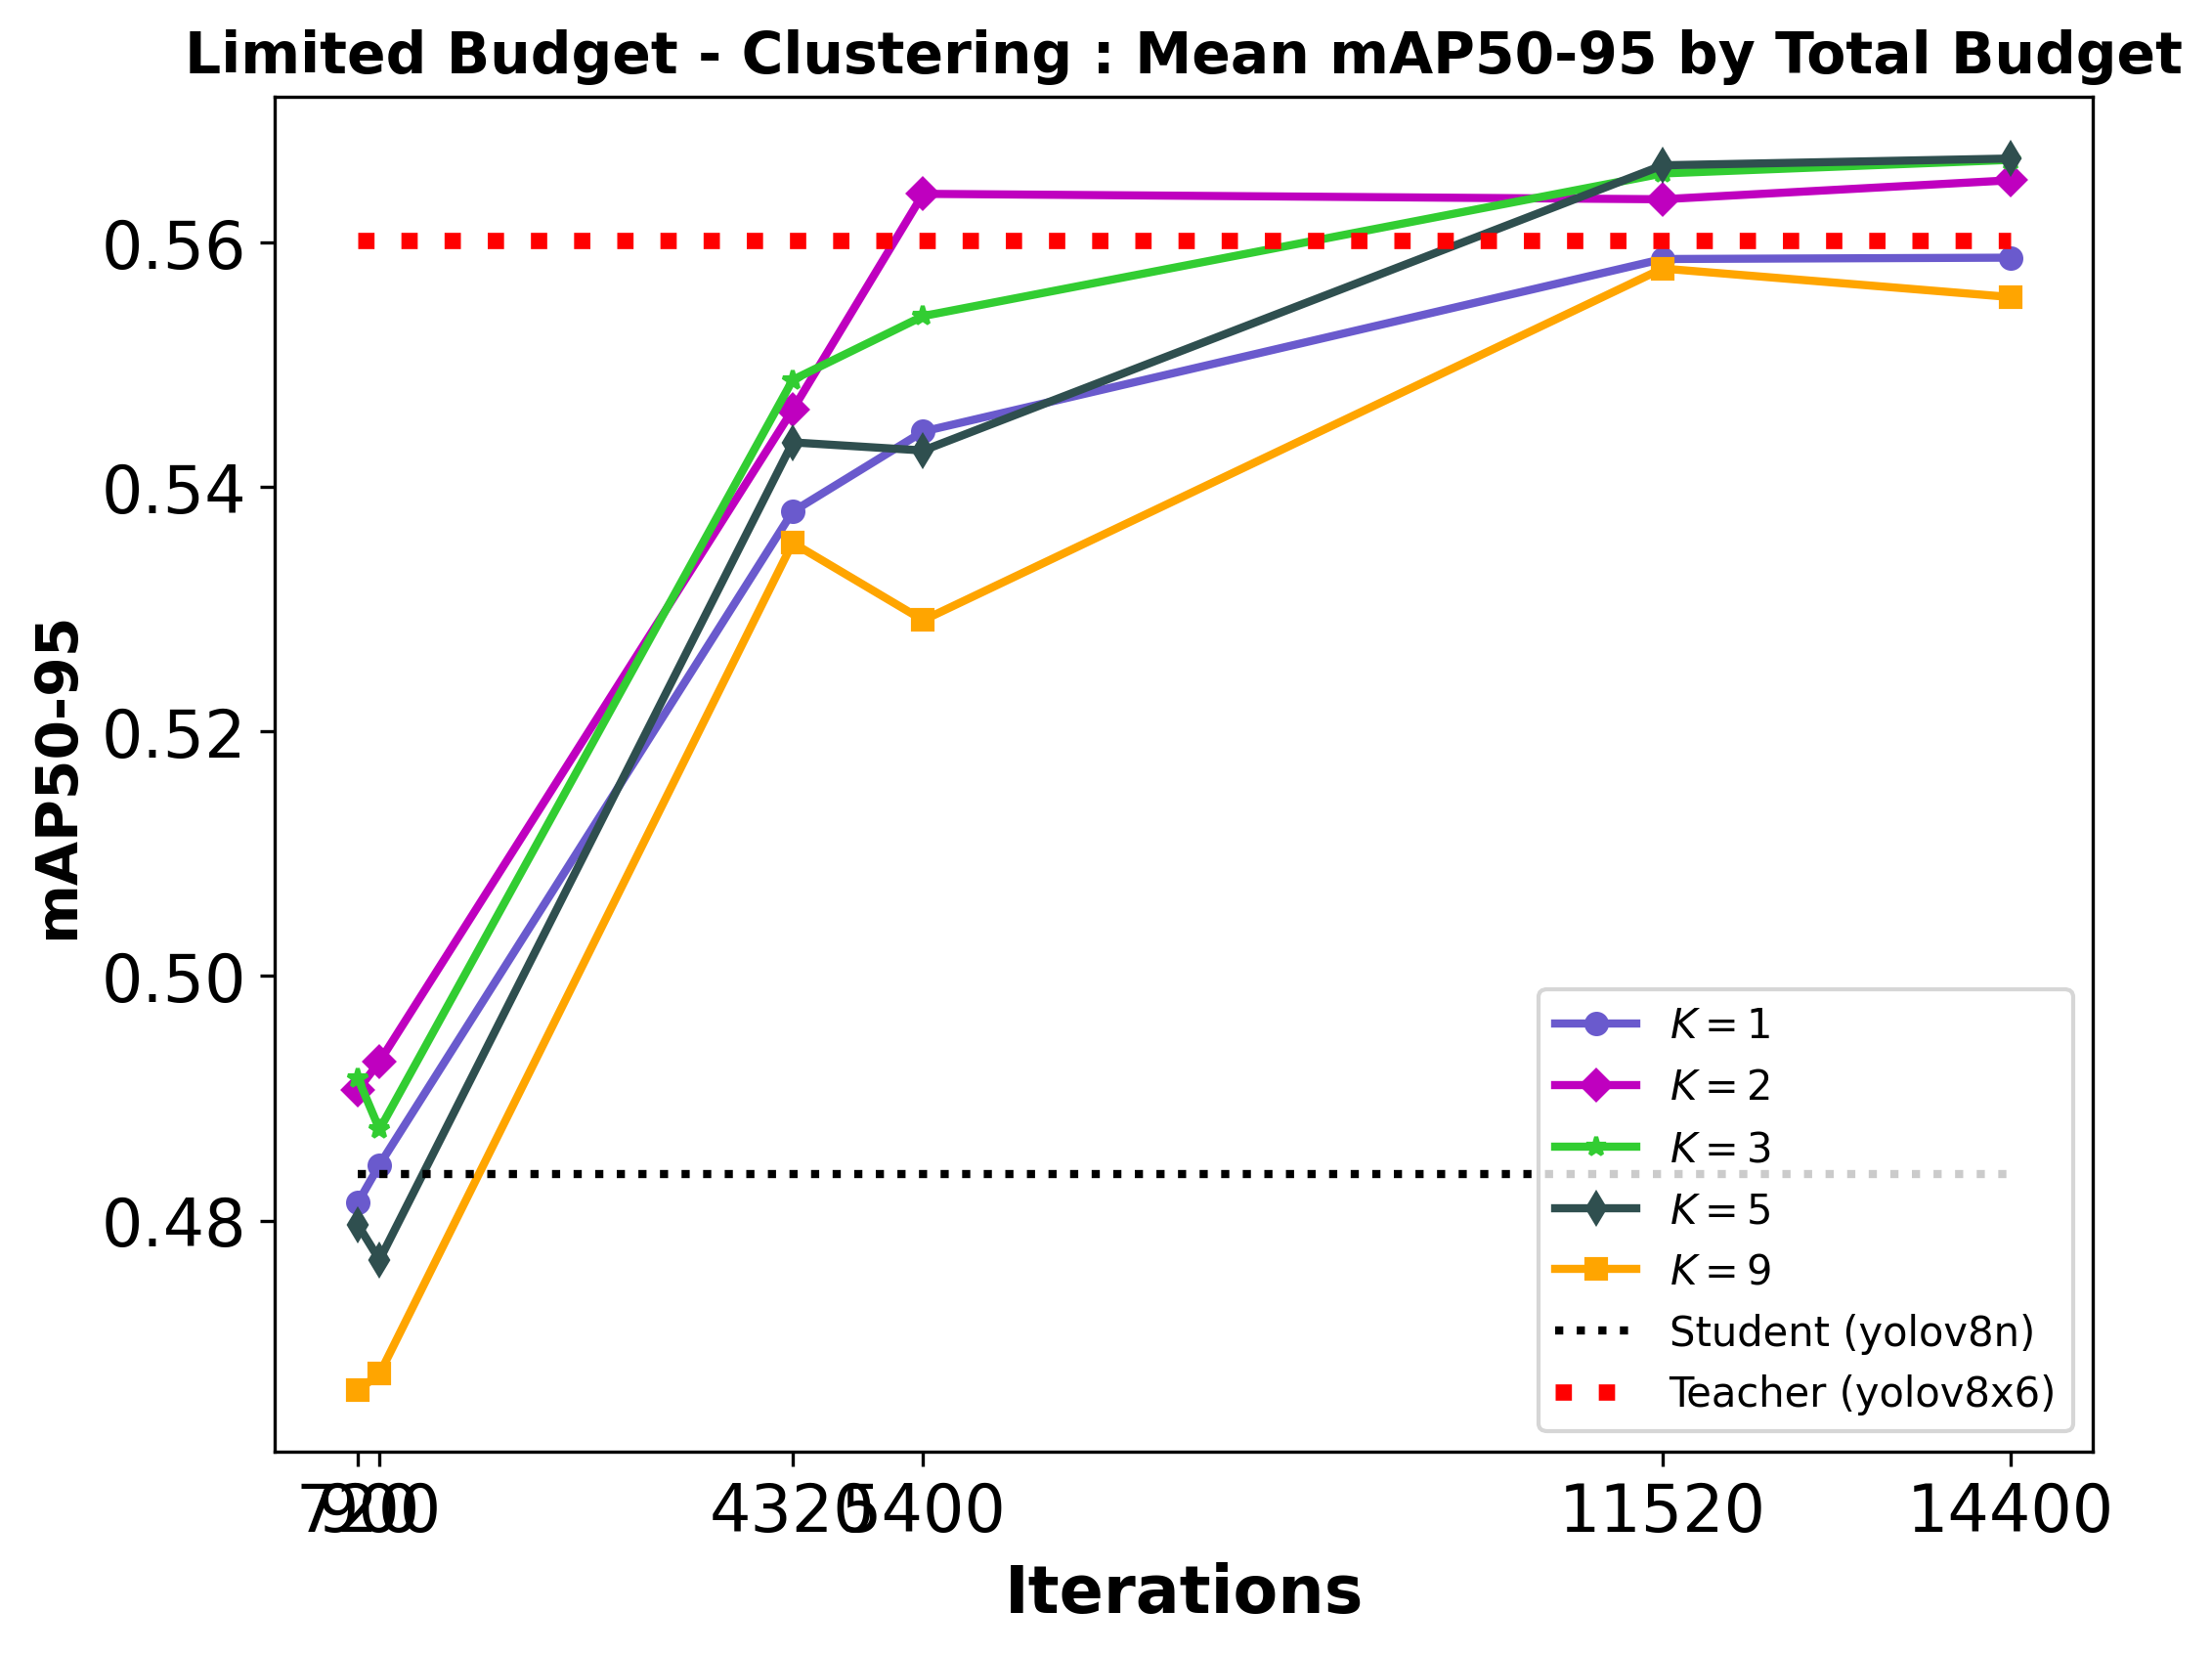

In [50]:
# List of all paths
paths = ["C:/Users/dani/inference/WALT-VAREPOCH/inference_results.csv"]

for path in paths:
    dfs.append(pd.read_csv(path))
    
# Concatenate all the dataframes into one
df_varepoch = pd.concat(dfs, ignore_index=True)
df_varepoch['source_combo'] = list(zip(df_varepoch['source_domain'], df_varepoch['source_period']))
toprint, _ , _ = filter_df(df_varepoch,
                           same_domain=True,
                           strategies=['thresholded-top-confidence-max'])

toprint.to_csv(r'E:\manjah\Documents\varepoch.csv', index=False)  # Set index=False if you don't want to save the index


samples_varepoch=[16, 96, 256]
df_it=total_maturity_cluster(restricted_dom_periods, 
                               'thresholded-top-confidence-max', 
                                samples_varepoch, 
                                 clusters, 
                                 df_varepoch, 
                                 restricted_dom_periods)

df_it.to_csv(r'E:\manjah\Documents\varepoch.csv', index=False)  # Set index=False if you don't want to save the index


plot_style={
    'title': 'Limited Budget - Clustering : Mean mAP50-95 by Total Budget',
    'xlabel': r'Iterations',
    'filename':"E:\Download\images-journal\sb-week-clustering-iteration.pdf"
}

benchmark_strategies_plot(df_it, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style,
                          pivot='iterations')

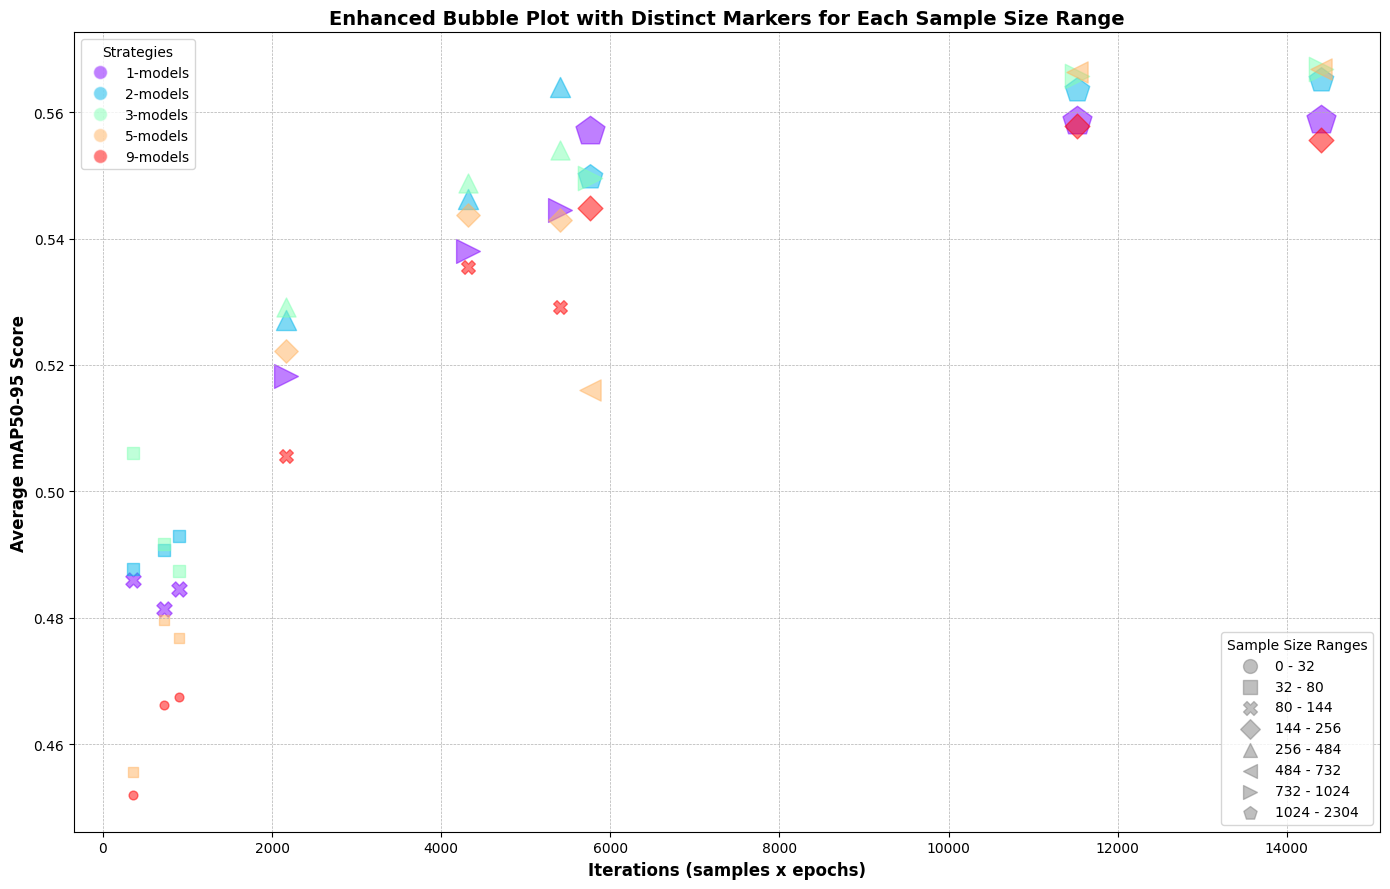

In [45]:
data = df_it

# Grouping by 'strategy' and 'iterations' and calculating mean of 'mAP50-95' and 'samples'
grouped_strategy_data = data.groupby(['strategy', 'iterations']).agg({'mAP50-95':'mean', 'samples':'mean'}).reset_index()
unique_strategies = grouped_strategy_data['strategy'].unique()

# Function to adjust bubble sizes so that they represent area
def adjust_bubble_sizes(sizes):
    return np.sqrt(sizes) * 10

# Create color map for different strategies
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_strategies)))
strategy_colors = dict(zip(unique_strategies, colors))

# Defining the sample size ranges and their associated markers
new_sample_size_ranges = [(0, 32), (32, 80), (80, 144), (144, 256), (256, 484), (484, 732), (732, 1024), (1024, 2304)]
eight_marker_types = ['o', 's', 'X', 'D', '^', '<', '>', 'p']  # Including additional markers
range_markers = {range_: eight_marker_types[i % len(eight_marker_types)] for i, range_ in enumerate(new_sample_size_ranges)}

# Function to determine the marker for a given sample size
def get_marker_for_sample_size(size):
    for range_, marker in range_markers.items():
        if range_[0] < size <= range_[1]:
            return marker
    return 'o'  # Default marker in case of an outlier

# Plot setup
plt.figure(figsize=(14, 9))
plt.gca().set_facecolor('white')

# Axes labels (size and boldness)
plt.xlabel('Iterations (samples x epochs)', fontsize=12, fontweight='bold')
plt.ylabel('Average mAP50-95 Score', fontsize=12, fontweight='bold')

# Creating the plot with strategy colors and markers for sample sizes
for strategy in unique_strategies:
    strategy_data = grouped_strategy_data[grouped_strategy_data['strategy'] == strategy]
    for _, row in strategy_data.iterrows():
        marker = get_marker_for_sample_size(row['samples'])
        adjusted_sizes = adjust_bubble_sizes([row['samples']])
        plt.scatter(row['iterations'], row['mAP50-95'], s=adjusted_sizes, 
                    color=strategy_colors[strategy], alpha=0.5, marker=marker)

# Title and Gridlines
plt.title('Enhanced Bubble Plot with Distinct Markers for Each Sample Size Range', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Strategy legend in the upper left corner
strategy_patches = [plt.Line2D([0], [0], marker='o', color='w', label=strategy,
                               markerfacecolor=strategy_colors[strategy], markersize=10, alpha=0.5) for strategy in unique_strategies]
strategy_legend = plt.legend(handles=strategy_patches, title="Strategies", loc='upper left', fontsize=10)

# Sample size range legend with eight distinct markers
for range_, marker in range_markers.items():
    label = f"{range_[0]} - {range_[1]}" if range_[1] != float('inf') else f"Above {range_[0]}"
    plt.scatter([], [], s=adjust_bubble_sizes([100]), color='gray', alpha=0.5, marker=marker, label=label)
size_range_legend = plt.legend(title="Sample Size Ranges", loc='lower right', scatterpoints=1, frameon=True, fontsize=10)

# Add strategy legend back to the plot
plt.gca().add_artist(strategy_legend)

plt.tight_layout()
plt.show()


<h1> <font color="blue"> 5. Incremental deployment </font><h1>

<h1> <font color="blue"> 5.1 Generalisation loss of fine-tuned model</font><h1>

In [ ]:
from matplotlib.patches import Rectangle

df_multistream['source_combo'] = list(zip(df_multistream['source_domain'], df_multistream['source_period'], df_multistream['samples']))# , ))#, df_multistream['student'], df_multistream['strategy'],))

samples_2iteration=[10000,24000,25000,45000,20000]
domains=['cam6o7o8','cam1o3','cam2o9','cam4o5o6o7o8','cam5o6o7o8','cam1o2o3o9','cam1o2o3o4o5o6o7o8o9','camo2o3o4o5o6o7o8o9']
student=['yolov8n']
strat=['top-confidence-max']
df_twoiteration_multistream,_,_ = filter_df(df_multistream,
                                            strategies=strat,
                                            students=student,
                                            source_domains=domains,
                                            samples=samples_2iteration)
grouped_df = df_twoiteration_multistream.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

#Plotting the first heatmap (without any adjustments)
#plt.figure(figsize=(15,15)) 
#sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
#plt.title('Heatmap between Source Domain and Target Domain')
#plt.xlabel('Target Domain')
#plt.ylabel('Source Domain')
#plt.show()


yolo_map50=yolov8n_df['mAP50-95']
#display(yolo_map50)


    
yolo_map50_list = yolo_map50.reset_index(drop=True).tolist()
pivot_df_s = pivot_df.apply(lambda row: row - yolo_map50_list, axis=1)
plt.figure(figsize=(15,15))
ax = sns.heatmap(pivot_df_s, annot=True, vmin=-0.01, vmax=0, cmap='YlGnBu')
plt.title('Comparative Generalization Loss: Specialized Model Minus YOLO-COCO on WALT-dataset', color="blue",weight="bold")
plt.xlabel('Target Domain', weight='bold')  # x-axis label in bold
plt.ylabel('Source Domain',weight='bold')

# Assume restricted_dom_periods is defined somewhere in your existing code
for i, row_val in enumerate(pivot_df_s.index):
    # Extract the source_domain and source_period from row_val if needed
    source_domain, source_period, samples = row_val  # Update this line based on your actual row_val structure
    # Compute inc_domains and out_domains for this source_domain
    _, inc_domains, _, _ = process_domains_periods(source_domain, source_period, restricted_dom_periods)
    
    for j, col_val in enumerate(pivot_df_s.columns):
        if any(domain in col_val for domain in inc_domains):
            ax.text(j+0.3, i+0.3, '*', color='red', ha='center', va='center', fontsize=24)
# Remove y-axis labels
ax.set_yticklabels([])
for label in ax.get_xticklabels():
    label.set_weight("bold")
plt.show()

<h1> <font color="blue"> 5.2. TWO -iterations fine-tuning, specialized students don't make them better learner </font><h1>


In the TWO-iteration fine-tuning experiment conducted hastily, two methodological errors were identified. First, the model used images based on the top-confidence of YOLOv8nano, rather than its own confidence level. Second, the model outperformed the teacher with a performance score of 0.60 compared to the teacher's 0.56.

Two alternative strategies were suggested:

Use images where the model has the highest confidence and rely on its own annotations.
Use images where the model has the lowest confidence and have them annotated by a human.
A subsequent test should be conducted on cameras 1, 2, 4, 6, 9, with samples ranging from 32 to 304, to see if using the model's own confidence improves performance.

A preliminary conclusion suggests that for effective distillation, there must be a performance gap between the teacher and the student; otherwise, the learning process could be negatively impacted. The exact quantification of this performance gap remains undefined.

Trying larger models is an option, but based on the current results, the approach is not recommended.

In [ ]:
samples = [45000]
strategy=['top-confidence-max']
strat_df,mean_strat,_= filter_df(df_multistream,
                    strategies=strategy, 
                    samples=samples,
                    source_domains=['cam1o2o3o4o5o6o7o8o9'])


stats_data = perform_statistical_tests(strat_df, yolov8n_df,'strategy','yolov8x6')

data = {'samples': samples, 
        'strategy': strategy, 
        'mean': mean_strat,
        'mean_yolov8n': mean_yolov8n,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
display(formatted_data)

<h1> <font color="blue"> 6. Domain-shift </font><h1>

What happens if a fine-tuned model is translated to a new domain? 

We observe under-performance. The development of context aware-models is necessary



Il faut un ré-entrainement sur la nouvelle caméra ajoutée 
en tenant compte des autres caméras. Le réapprentissage sur des nouvelles distributions et à prendre avec précaution. 

Spécialiser est risqué et s'il est possible de centraliser, nous recommandons de prendre une décision basée sur la heatmap. 
Partir d'un modèle spécialisé pour le fine-tuning est non recommandé. Il y'a quelque chose qu'on ne comprend pas. La spécialization est faite au détriment d'une généralization et donc le procédé doit être répété. à partir d'un modèle YOLO de base général. 
    

    La spécialisiation ne peut-être intéressante que si le modèle avait une base générale. Si le modèle est spécialisé. Il n'y aucun intérêt. 
    
    Dans un déploiement scalable
    
    
Domain specialization but at what price?

-SBAD remains a scalable approach but to guarantee the performance, the theta has to be a general purpose model.Two iterations fine-tuning

    The teacher has to be as general

In [ ]:
df_aicity['source_combo'] = list(zip(df_aicity['source_domain'], df_aicity['source_period'], df_aicity['samples']))# , ))#, df_multistream['student'], df_multistream['strategy'],))

samples_2iteration=[10000,25000,45000,20000]
domains=['cam6o7o8','cam1o3','cam2o9','cam4o5o6o7o8','cam5o6o7o8','cam1o2o3o9','cam1o2o3o4o5o6o7o8o9']
student=['yolov8n']
strat=['top-confidence-max']
df_domain_shift,_,_ = filter_df(df_aicity,
                                strategies=strat,
                                students=student,
                                source_domains=domains,
                                samples=samples_2iteration)
grouped_df = df_domain_shift.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

#Plotting the first heatmap (without any adjustments)
#plt.figure(figsize=(15,15)) 
#sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
#plt.title('Heatmap between Source Domain and Target Domain')
#plt.xlabel('Target Domain')
#plt.ylabel('Source Domain')
#plt.show()


df_yolov8n_aicity,_,_=filter_df(df_aicity,
                                strategies=['yolov8n'])
yolo_map50=df_yolov8n_aicity['mAP50-95']
yolo_map50_list = yolo_map50.reset_index(drop=True).tolist()
display(yolo_map50_list)
pivot_df_s = pivot_df.apply(lambda row: row - yolo_map50_list, axis=1)
plt.figure(figsize=(15,15))
ax = sns.heatmap(pivot_df_s, annot=True, vmin=-0.01, vmax=0, cmap='YlGnBu')
plt.title('Domain shift: Specialized Model ON WALT Minus YOLO-COCO for the AI-city dataset', color="blue",weight="bold")
plt.xlabel('Target Domain', weight='bold')  # x-axis label in bold
plt.ylabel('Source Domain',weight='bold')

# Assume restricted_dom_periods is defined somewhere in your existing code
for i, row_val in enumerate(pivot_df_s.index):
    # Extract the source_domain and source_period from row_val if needed
    source_domain, source_period, samples = row_val  # Update this line based on your actual row_val structure
    # Compute inc_domains and out_domains for this source_domain
    _, inc_domains, _, _ = process_domains_periods(source_domain, source_period, restricted_dom_periods)
    
    for j, col_val in enumerate(pivot_df_s.columns):
        if any(domain in col_val for domain in inc_domains):
            ax.text(j+0.3, i+0.3, '*', color='red', ha='center', va='center', fontsize=24)
# Remove y-axis labels
for label in ax.get_xticklabels():
    label.set_weight("bold")
plt.show()


<h1> <font color="blue"> ANNEX STREAM-BASED </font><h1>

<h2> <font color="blue"> A. Large Stream Based Week </font><h2>

In [ ]:
# Filter for a specific sample, strategy, and the domain-period combinations
df_strategies_largesb, _ , _  = filter_df(df_all,
                                     same_domain=True,
                                     source_dataset=['WALT'],
                                     strategies=strategies_largesb,
                                     samples=samples_large,
                                     dom_periods=restricted_dom_periods,
                                     students=['yolov8n'],
                                     teachers=['yolov8x6'])


df_random_largesb, _ , _ = filter_df(df_all, 
                                     same_domain=True,
                                     samples=samples_large,
                                     dom_periods=restricted_dom_periods,
                                     prefix_random="uniform-random09160")

plot_style={
    'title': 'Stream-Based Strategies: Mean mAP50-95 per Samples',
    'filename':"E:\Download\images-journal\sb-week-single-large.pdf"
}


pv=benchmark_strategies_plot(df_strategies_largesb,
                          strategy_styles=sb_strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_largesb,
                          prefix_random=prefix_random_sb)

<h2> <font color="blue"> A. Generation of side by side values for clustering </font><h2>

In [ ]:
def generate_df(cam_week_tuples, strategy, samples, df, df_multistream):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data={}
        cam, week = cam_week_tuple
        data["cam"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters)
        # Loop over each sample
        for sample in samples:
            data["smpls self"]=sample
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample])
            data["self"]=mean_cam_self
            for cls in inclusters:
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df_multistream, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam])
                
                data[f"smpls cls_{cls['number']}"]=number_of_samples
                data[f"cam cls_{cls['number']}"]=b
                data[f"mean cls_{cls['number']}"] = cluster_mean
                
            for cls in outclusters:
                anti_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], 
                                                               restricted_dom_periods)
                number_of_samples = len(anti_cameras)*sample
                data[f"anticam cls_{cls['number']}"]=b
                data[f"smpls anti_cls{cls['number']}"]=number_of_samples
                _,anticluster_mean,_= filter_df(df_multistream, 
                                                strategies=[strategy], 
                                                source_domains=[cls['source_domain']],
                                                source_periods=[cls['source_period']], 
                                                samples=[number_of_samples],
                                                target_domain=[cam])
                data[f"mean anticls_{cls['number']}"]=anticluster_mean
                # Append the results to the DataFrame
            result_df = pd.concat([result_df, pd.DataFrame([data])], ignore_index=True)
        
    return result_df


samples = [16,32,96,216]   # replace with your samples
df_cluster2 = generate_df(scal_dom_periods, 'thresholded-top-confidence-max', samples, df_stream, df_multistream)
display(df_cluster2)
grouped_df = df_cluster2.groupby(['smpls self']).mean(numeric_only=True)

<h2> <font color="blue"> B. Generation of side by side values for clustering (obsolete) </font><h2>

In [ ]:
# Generating a synthetic dataset for visualization
np.random.seed(0)  # For reproducibility

# Generating data for 'thresholded-top-confidence-max' strategy
thresh_top_data = pd.DataFrame({
    'total_iterations': np.random.randint(100, 2000, 10),
    'mAP50-95': np.random.uniform(0.4, 0.6, 10),
    'strategy': 'thresholded-top-confidence-max'
})

# Generating data for 'n-first' strategy
n_first_data_synthetic = pd.DataFrame({
    'total_iterations': np.random.randint(100, 2000, 10),
    'mAP50-95': np.random.uniform(0.3, 0.5, 10),
    'strategy': 'n-first'
})

# Combining the synthetic data
combined_synthetic_data = pd.concat([thresh_top_data, n_first_data_synthetic])

# Creating color-coded density plots for each strategy using the synthetic data
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Density plot for 'thresholded-top-confidence-max' strategy
sns.kdeplot(x=thresh_top_data['total_iterations'], y=thresh_top_data['mAP50-95'], ax=ax[0], cmap="Blues", fill=True)
ax[0].set_title('Density Plot for Thresholded-Top-Confidence-Max Strategy')
ax[0].set_xlabel('Total Iterations')
ax[0].set_ylabel('mAP50-95')

# Density plot for 'n-first' strategy
sns.kdeplot(x=n_first_data_synthetic['total_iterations'], y=n_first_data_synthetic['mAP50-95'], ax=ax[1], cmap="Reds", fill=True)
ax[1].set_title('Density Plot for N-First Strategy')
ax[1].set_xlabel('Total Iterations')
ax[1].set_ylabel('mAP50-95')

plt.tight_layout()
plt.show()


In [ ]:
# Generating a synthetic dataset for visualization
np.random.seed(0)  # For reproducibility

# Generating data for 'thresholded-top-confidence-max' strategy
thresh_top_data = pd.DataFrame({
    'total_iterations': np.random.randint(100, 2000, 10),
    'mAP50-95': np.random.uniform(0.4, 0.6, 10),
    'samples': np.random.choice([16, 32, 48, 64, 128], 10),
    'strategy': 'thresholded-top-confidence-max'
})

# Generating data for 'n-first' strategy
n_first_data_synthetic = pd.DataFrame({
    'total_iterations': np.random.randint(10, 2000, 10),
    'mAP50-95': np.random.uniform(0.3, 0.5, 10),
    'samples': np.random.choice([16, 32, 48, 64, 128], 10),
    'strategy': 'n-first'
})

# Generating data for 'n-first' strategy
model_4_data_synthetic = pd.DataFrame({
    'total_iterations': np.random.randint(10, 2000, 10),
    'mAP50-95': np.random.uniform(0.5, 0.7, 10),
    'samples': np.random.choice([16, 32, 48, 64, 128], 10),
    'strategy': 'model-4'
})


# Combining the synthetic data
combined_synthetic_data = pd.concat([thresh_top_data, n_first_data_synthetic, model_4_data_synthetic])

# Scaling the sample size for bubble size
max_sample_size = combined_synthetic_data['samples'].max()
combined_synthetic_data['scaled_sample_size'] = combined_synthetic_data['samples'] / max_sample_size * 100  # Scale for visibility

# Creating the Bubble Plot
plt.figure(figsize=(10, 6))
bubble_plot = sns.scatterplot(data=combined_synthetic_data, x='total_iterations', y='mAP50-95', 
                              size='scaled_sample_size', hue='strategy', sizes=(20, 200), alpha=0.7, legend='full')

plt.title('Bubble Plot of Strategies: mAP50-95 vs. Total Iterations')
plt.xlabel('Total Iterations (SAMPLES x EPOCHS/16)')
plt.ylabel('mAP50-95')
bubble_plot.legend(title='Strategy & Sample Size')
plt.show()


# Creating the combined scatter and line plot
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(data=combined_synthetic_data, x='total_iterations', y='mAP50-95', hue='strategy', size='samples', sizes=(20, 200), alpha=0.7)

# Line plot to show the trend
sns.lineplot(data=combined_synthetic_data, x='total_iterations', y='mAP50-95', hue='strategy', style='strategy', markers=True, dashes=False)

plt.title('Combined Scatter and Line Plot for Strategies')
plt.xlabel('Total Iterations')
plt.ylabel('mAP50-95')
plt.legend(title='Strategy & Sample Size')
plt.show()


# Creating the Overlayed 2D Density Plot
plt.figure(figsize=(12, 8))
sns.kdeplot(data=combined_synthetic_data, x='total_iterations', y='mAP50-95', hue='strategy', fill=True, alpha=0.5)
plt.title('Overlayed 2D Density Plot for Strategies')
plt.xlabel('Total Iterations')
plt.ylabel('mAP50-95')
plt.legend(title='Strategy')
plt.show()

<h2> <font color="blue"> C. Same samples clustering different strategies of clustering </font><h2>

In [ ]:
# Create an empty DataFrame for final results
final_results_df = pd.DataFrame()
for cluster in clusters:
    results_df = analyze_performance(cluster["number"], 
                                     selected_strategy, 
                                     selected_sample_sizes,  
                                     cluster["source_domain"], 
                                     cluster["source_period"],
                                     restricted_dom_periods,
                                     df_stream,
                                     df_multistream)
    final_results_df = pd.concat([final_results_df, results_df])


display(final_results_df)

In [ ]:
################# LATEX OUTPUTS



rename_dict_large_sample = {
    'n-first': 'n-first',
    'thresholded09160-least-confidence-max': 'thresh-least-confidence',
    'thresholded09160-top-confidence-max': 'thres-top-confidence',
}

caption_largesamplesstram= "Values for each strategy of the total per seed versus samples"
label_large_sample= "tab:sblargestrategies"
latex_output_large_sample= to_latex_mean_std(df_pivot_largesb, 
                                         caption=caption_largesamplesstram, 
                                         label=label_large_sample,
                                         rename_dict=rename_dict_large_sample,
                                         environment="sidewaystable")



print(latex_output_large_sample)



rename_dict = {
    'n-first': 'n-first',
    'thresholded-least-confidence-max': 'thresh-least-confidence',
    'thresholded-top-confidence-max': 'thres-top-confidence'
}
caption = "Value of the stream-based strategies versus samples"
label = "tab:sbstrategies"
pivot_tbl_strat_sb = compute_pivot_tables(df_strategies_sb)
latex_output = to_latex_mean_std(pivot_tbl_strat_sb, caption=caption, label=label, rename_dict=rename_dict)
rename_dict_random = {
    'uniform-random-0': '0',
    'uniform-random-1': '1',
    'uniform-random-2': '2',
    'uniform-random-3': '3',
    'uniform-random-4': '4',
    'uniform-random-5': '5',
}

pivot_table_random_sb = compute_pivot_tables(df_random_sb)
caption_random = "Values of the uniform-random per seed versus samples"
label_random = "tab:sbstrategies_random"
latex_output_random = to_latex_mean_std(pivot_table_random_sb, 
                                         caption=caption_random, 
                                         label=label_random,
                                         rename_dict=rename_dict_random,
                                         environment="sidewaystable")

rename_dict_total = {
    'n-first': 'n-first',
    'thresholded-least-confidence-max': 'thresh-least-confidence',
    'thresholded-top-confidence-max': 'thres-top-confidence',
    'uniform-random-0': '0',
    'uniform-random-1': '1',
    'uniform-random-2': '2',
    'uniform-random-3': '3',
    'uniform-random-4': '4',
    'uniform-random-5': '5',
}

result_df_total= pd.merge(pivot_tbl_strat_sb, pivot_table_random_sb, on='samples', how='outer')
display(result_df_total)
caption_total= "Values of thetotalper seed versus samples"
label_total = "tab:sbstrategies_total"
latex_output_total= to_latex_mean_std(result_df_total, 
                                         caption=caption_total, 
                                         label=label_total,
                                         rename_dict=rename_dict_total,
                                         environment="sidewaystable")



#display(pivot_tbl_strat_sb)


#print(latex_output)
#print(latex_output_random)

#print(latex_output_total)

In [ ]:
def to_latex_mean_std(df, caption="", label="", rename_dict="", environment="table"):
    # Rename strategies for shorter/better display names
    if rename_dict:
        # Create a new DataFrame to hold mean ± std format
        result_df = pd.DataFrame(index=df.index)
        for old_name, new_name in rename_dict.items():
            mean_col = f"mean_{old_name}"
            std_col = f"std_{old_name}"
            
            # Format as "mean ± std"
            result_df[new_name] = df[mean_col].map('{:.3f}'.format) + " ± " + df[std_col].map('{:.2f}'.format)
    else:
        result_df = df.copy()
        
    # Get the number of columns and construct the column format string
    num_columns = result_df.shape[1]
    column_format = "|" + "c|" * (num_columns+1)
    
    # Convert to latex with Styler
    latex_str = result_df.style.to_latex(column_format=column_format, 
                                         position='htpb',
                                         label=label,
                                         caption=caption,
                                         hrules=True,
                                         clines="all;data",
                                         environment=environment)
    
    return latex_str#.replace("\\\\", "\\\\ \\hline").replace("\\bottomrule", "\\bottomrule \\bottomrule")

In [ ]:
########################################################################## STATISTICAL TESTS 



from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def perform_statistical_tests(df1, df2, df1_name, df2_name, suffix=''):
    if suffix:
        suffix = f'_{suffix}'
    
    if len(df1) < 3 or len(df2) < 3 or len(df1['mAP50-95']) == 0 or len(df2['mAP50-95']) == 0:
        return {
            f't-statistic{suffix}': None,
            f'p-value{suffix}': None,
            f'T-test result{suffix}': "Not testable",
            f'shapiro-wilk {df1_name}{suffix}': None,
            f'shapiro-wilk {df1_name} result{suffix}': "Not testable",
            f'shapiro-wilk {df2_name}{suffix}': None,
            f'shapiro-wilk {df2_name} result{suffix}': "Not testable",
            f'levene{suffix}': None,
            f'levene result{suffix}': "Not testable",
            f'mann-whitney u{suffix}': None,
            f'mann-whitney u result{suffix}': "Not testable"
        }

    t_statistic, p_value_t = ttest_ind(df1['mAP50-95'], df2['mAP50-95'])
    t_test_result = 'Means statistically different (reject H0)' if p_value_t < 0.05 else 'Means statistically undifferent'
    
    _, p_shapiro_df1 = shapiro(df1['mAP50-95'])
    shapiro_df1_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df1 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_shapiro_df2 = shapiro(df2['mAP50-95'])
    shapiro_df2_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df2 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_levene = levene(df1['mAP50-95'], df2['mAP50-95'])
    levene_result = 'Variances do not look equal (reject H0)' if p_levene < 0.05 else 'Variances look equal (fail to reject H0)'

    _, p_mannwhitney = mannwhitneyu(df1['mAP50-95'], df2['mAP50-95'])
    mannwhitney_result = 'Different distribution (reject H0)' if p_mannwhitney < 0.05 else 'Same distribution (fail to reject H0)'

    data = {
        f't-statistic{suffix}': t_statistic, 
        f'p-value{suffix}': p_value_t,
        f'T-test result{suffix}': t_test_result,
        f'shapiro-wilk {df1_name}{suffix}': p_shapiro_df1,
        f'shapiro-wilk {df1_name} result{suffix}': shapiro_df1_result,
        f'shapiro-wilk {df2_name}{suffix}': p_shapiro_df2,
        f'shapiro-wilk {df2_name} result{suffix}': shapiro_df2_result,
        f'levene{suffix}': p_levene,
        f'levene result{suffix}': levene_result,
        f'mann-whitney u{suffix}': p_mannwhitney,
        f'mann-whitney u result{suffix}': mannwhitney_result
    }

    return data

def conduct_anova_and_tukey(dataframe_list, names, alpha=0.1):
    """
    Conducts ANOVA and Tukey HSD tests on multiple dataframes.
    
    Args:
    dataframe_list: list of pandas dataframes to be analyzed.
    names: a list of strings, specifying the names (or sources) of the dataframes.
    alpha: significance level for the Tukey HSD test.
    
    Returns:
    a tuple (anova_result, tukey_results)
    """
    
    # Error checking: make sure we have as many names as dataframes in the list
    if len(dataframe_list) != len(names):
        raise ValueError("The number of dataframes should match the number of names.")
    
    # Add source column and combine dataframes
    combined_list = []
    for df, name in zip(dataframe_list, names):
        df_copy = df.copy()
        df_copy['source'] = name
        combined_list.append(df_copy)
        
    combined_df = pd.concat(combined_list, ignore_index=True)
    
    # Rename mAP50-95 column for compatibility with patsy formula
    combined_df.rename(columns={'mAP50-95': 'mAP50_95'}, inplace=True)
    
    # Conduct ANOVA
    model = ols('mAP50_95 ~ source', data=combined_df).fit()
    anova_result = sm.stats.anova_lm(model, typ=2)
    
    # Create lists for the Tukey HSD test
    values = combined_df['mAP50_95'].tolist()
    labels = combined_df['source'].tolist()
    
    # Conduct Tukey HSD test
    tukey_results = pairwise_tukeyhsd(values, labels, alpha=alpha)
    
    return anova_result, tukey_results

In [ ]:
sample = [256]
strategy1=['thresholded-top-confidence-max']
str1_short='top-conf'
strategy2=['thresholded-least-confidence-max']
str2_short='least-conf'
strategy3=['n-first']
str3_short='nfirst'


strat1_df, mean_strat1, std_strat1 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy1,
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

strat2_df,mean_strat2, std_strat2= filter_df(df_stream,
                                             same_domain=True,
                                             strategies=strategy2, 
                                             samples=sample,
                                             dom_periods=restricted_dom_periods)
            
strat3_df, mean_strat3, std_strat3 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy3, 
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

yolov8n_df, mean_yolov8n, c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8n'],
                                        samples=[0])

yolov8x6_df,mean_yolov8x6,c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8x6'],samples=[0])

stats_data = perform_statistical_tests(strat1_df, strat3_df, str1_short, str3_short)

data = {'samples': sample, 
        'strategy1': strategy1,
        'strategy2':strategy2,
        'strategy3':strategy3,
        'mean_strat1': mean_strat1,
        'std_strat1': std_strat1,
        'mean_strat2': mean_strat2,
        'std_strat2': std_strat2,
        'mean_strat3': mean_strat3,
        'std_strat3': std_strat3,
        'mean_yolov8n': mean_yolov8n,
        'mean_yolov8x6': mean_yolov8x6,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
#display(formatted_data)


dataframes = [strat1_df, strat2_df, strat3_df, yolov8n_df, yolov8x6_df]
names = [str1_short, str2_short, str3_short, 'yolov8n', 'yolov8x6']

anova_res, tukey_res = conduct_anova_and_tukey(dataframes, names, alpha=0.05)


#print(anova_res)
#print(tukey_res)

In [ ]:
# Define the column names to display
selected_strategy =['n-first','uniform-random-0','thresholded-top-confidence-max']
selected_sample_sizes= [96,216]

display_columns = ['cluster numbers', 'cameras', 'mean self', 'mean multi', 'T-test result']


def highlight_rows(s):
    styles = [''] * len(s)
    for i, (mean_multi, mean_single) in enumerate(zip(s['mean multi'], s['mean self'])):
        if mean_multi > mean_single:
            styles[i] = 'color: red'
    return styles

# Now, loop over unique strategies and sample sizes
for strategy in selected_strategy:
    for sample in selected_sample_sizes:
        strategy_sample_df = final_results_df[(final_results_df['strategy'] == strategy) 
                                              & (final_results_df['samples'] == sample)]
        
        # If DataFrame is not empty, display it
        if not strategy_sample_df.empty:
            # Print title in blue with HTML tags
            display(HTML(f"<h2 style='color:blue;'><b>Strategy: {strategy}, Sample Size: {sample}</b></h2>"))
            
            # Note: use pd.set_option to format all floats to 3 decimal places
            with pd.option_context('display.float_format', '{:.3f}'.format): 
                df_to_display = strategy_sample_df[display_columns].reset_index(drop=True)
                
                # Apply row highlighter
                df_to_display.style.apply(highlight_rows, axis=1)
                
                # Display the DataFrame
                display(df_to_display)
        else:
            print(f"No data available for strategy {strategy} and sample size {sample}")


In [ ]:
def add_row_to_results(df, data):
    new_row = pd.DataFrame([data])
    return pd.concat([df, new_row], ignore_index=True)


def test_strategies(number_cluster,
                    cluster_content, 
                    selected_sample_sizes,
                    selected_strategy,
                    selected_source_domain_multi,
                    selected_source_period_multi,
                    restricted_eligible_clustering_df,
                    df_multistream,
                    excluded_domains_df,
                    included_target_domains,
                    excluded_target_domains):
    
    results = pd.DataFrame()
    
    for sample_size in selected_sample_sizes:
        for strategy in selected_strategy:
            
            #IN CLUSTER COMPUTATION 
            one_strategy_one_sample_df, mean_self,_ = filter_df(restricted_eligible_clustering_df, 
                                                                 strategies=[strategy], 
                                                                 samples=[sample_size])
            
            filtered_df_multistream, mean_multi,_ = filter_df(df_multistream, 
                                                               strategies=[strategy], 
                                                               samples= [sample_size], 
                                                               source_periods=[selected_source_period_multi], 
                                                               source_domains=[selected_source_domain_multi], 
                                                               excluded_domains=[excluded_target_domains])
            
            stats_in= perform_statistical_tests(one_strategy_one_sample_df, filtered_df_multistream,'single-stream','multi-stream')
            
            #OUT CLUSTER COMPUTATION
            one_strategy_one_sample_df_out,mean_self_out,c = filter_df(excluded_domains_df,
                                                                         strategies = [strategy], 
                                                                         samples=[sample_size])
            
            filtered_df_multistream_out,mean_multi_out,c = filter_df(df_multistream,
                                                                       strategies=[strategy], 
                                                                       samples=[sample_size], 
                                                                       source_periods=[selected_source_period_multi], 
                                                                       source_domains=[selected_source_domain_multi], 
                                                                       excluded_domains=included_target_domains)

            stats_out = perform_statistical_tests(one_strategy_one_sample_df_out, 
                                                  filtered_df_multistream_out,
                                                  'single-stream',
                                                  'multi-stream','excl')
            
            data = {'samples': sample_size, 
                    'strategy': strategy, 
                    'mean self': mean_self,
                    'mean multi': mean_multi,
                    'cluster numbers': number_cluster,
                    'cameras': cluster_content,
                    **stats_in,
                    'mean self_out': mean_self,
                    'mean multi_out': mean_multi_out,
                    **stats_out}
            results = add_row_to_results(results, data)
        
    return results



def analyze_performance(number_cluster, 
                        selected_strategy,
                        sample_sizes,
                        source_domain, 
                        source_period,
                        eligible_clustering_domain_periods,
                        df_stream,
                        df_multistream):
    
    sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
    
    domain_periods, included_domains, excluded_domains_periods, excluded_domains = process_domains_periods(source_domain,source_period, eligible_clustering_domain_periods)
    
    included_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=domain_periods)
    
    excluded_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=excluded_domains_periods)
    
    cluster_cameras = ", ".join([cam for cam, _ in domain_periods])
    
    #print('Number of records:', len(restricted_eligible_clustering_df))
    #print('Mean mAP50-95:', restricted_eligible_clustering_df['mAP50-95'].mean())

    results_df = test_strategies(number_cluster,
                                 cluster_cameras,
                                 sample_sizes,
                                 selected_strategy,
                                 source_domain,
                                 source_period,
                                 included_domains_df,
                                 df_multistream,
                                 excluded_domains_df,
                                 included_domains,
                                 excluded_domains)
    
    return results_df